# Описание проекта: промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.

**Описание этапа обработки**  
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.  
Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).  
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.  
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

**Описание данных**  
Данные состоят из файлов, полученных из разных источников:

- data_arc_new.csv — данные об электродах;
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
- data_gas_new.csv — данные о продувке сплава газом;
- data_temp_new.csv — результаты измерения температуры;
- data_wire_new.csv — данные о проволочных материалах (объём);
- data_wire_time_new.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## Загрузка и подготовка данных

Установим новые библиотеки

In [1]:
# установим библиотеку визуализации пропущенных значений
!pip install -q missingno

Импортируем необходимые библиотеки

In [2]:
# импортируем необходимые библиотеки

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pylab as pl
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor

import missingno as msno
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.set_option('display.max_columns', None)


RANDOM_STATE = 110923 #зафиксируем значение RANDOM_STATE

Загрузим данные

In [3]:
# напишем функцию загрузки данных из файла
def down_load_file(file_name):
    try:
        dl_data = pd.read_csv(f'/datasets/{file_name}')
    except:
        dl_data = pd.read_csv(f'https://code.s3.yandex.net/datasets/{file_name}')
    return dl_data

In [4]:
df_arc = down_load_file('data_arc_new.csv')
df_bulk = down_load_file('data_bulk_new.csv')
df_bulk_time = down_load_file('data_bulk_time_new.csv')
df_gas = down_load_file('data_gas_new.csv')
df_temp = down_load_file('data_temp_new.csv')
df_wire = down_load_file('data_wire_new.csv')
df_wire_time  = down_load_file('data_wire_time_new.csv')

In [5]:
# созданим функцию по отображению данных в дата фрейме
def show_df_info(data):
    display('Размер таблицы:', data.shape)
    display(data.head(5))
    display(data.info())
    display(data.describe())
    #display('Количество явных дубликатов: ', data.duplicated().sum())
    #display('Количество пропушенных значений: ','\n', data.isna().sum())
    display('Отобразим пропущенные значения на графике (для общего понимания объема пропущенных значений):')
    msno.matrix(data, labels=True)

## Исследовательский анализ

### Изучим таблицу данных об электродах

'Размер таблицы:'

(14876, 5)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


'Отобразим пропущенные значения на графике (для общего понимания объема пропущенных значений):'

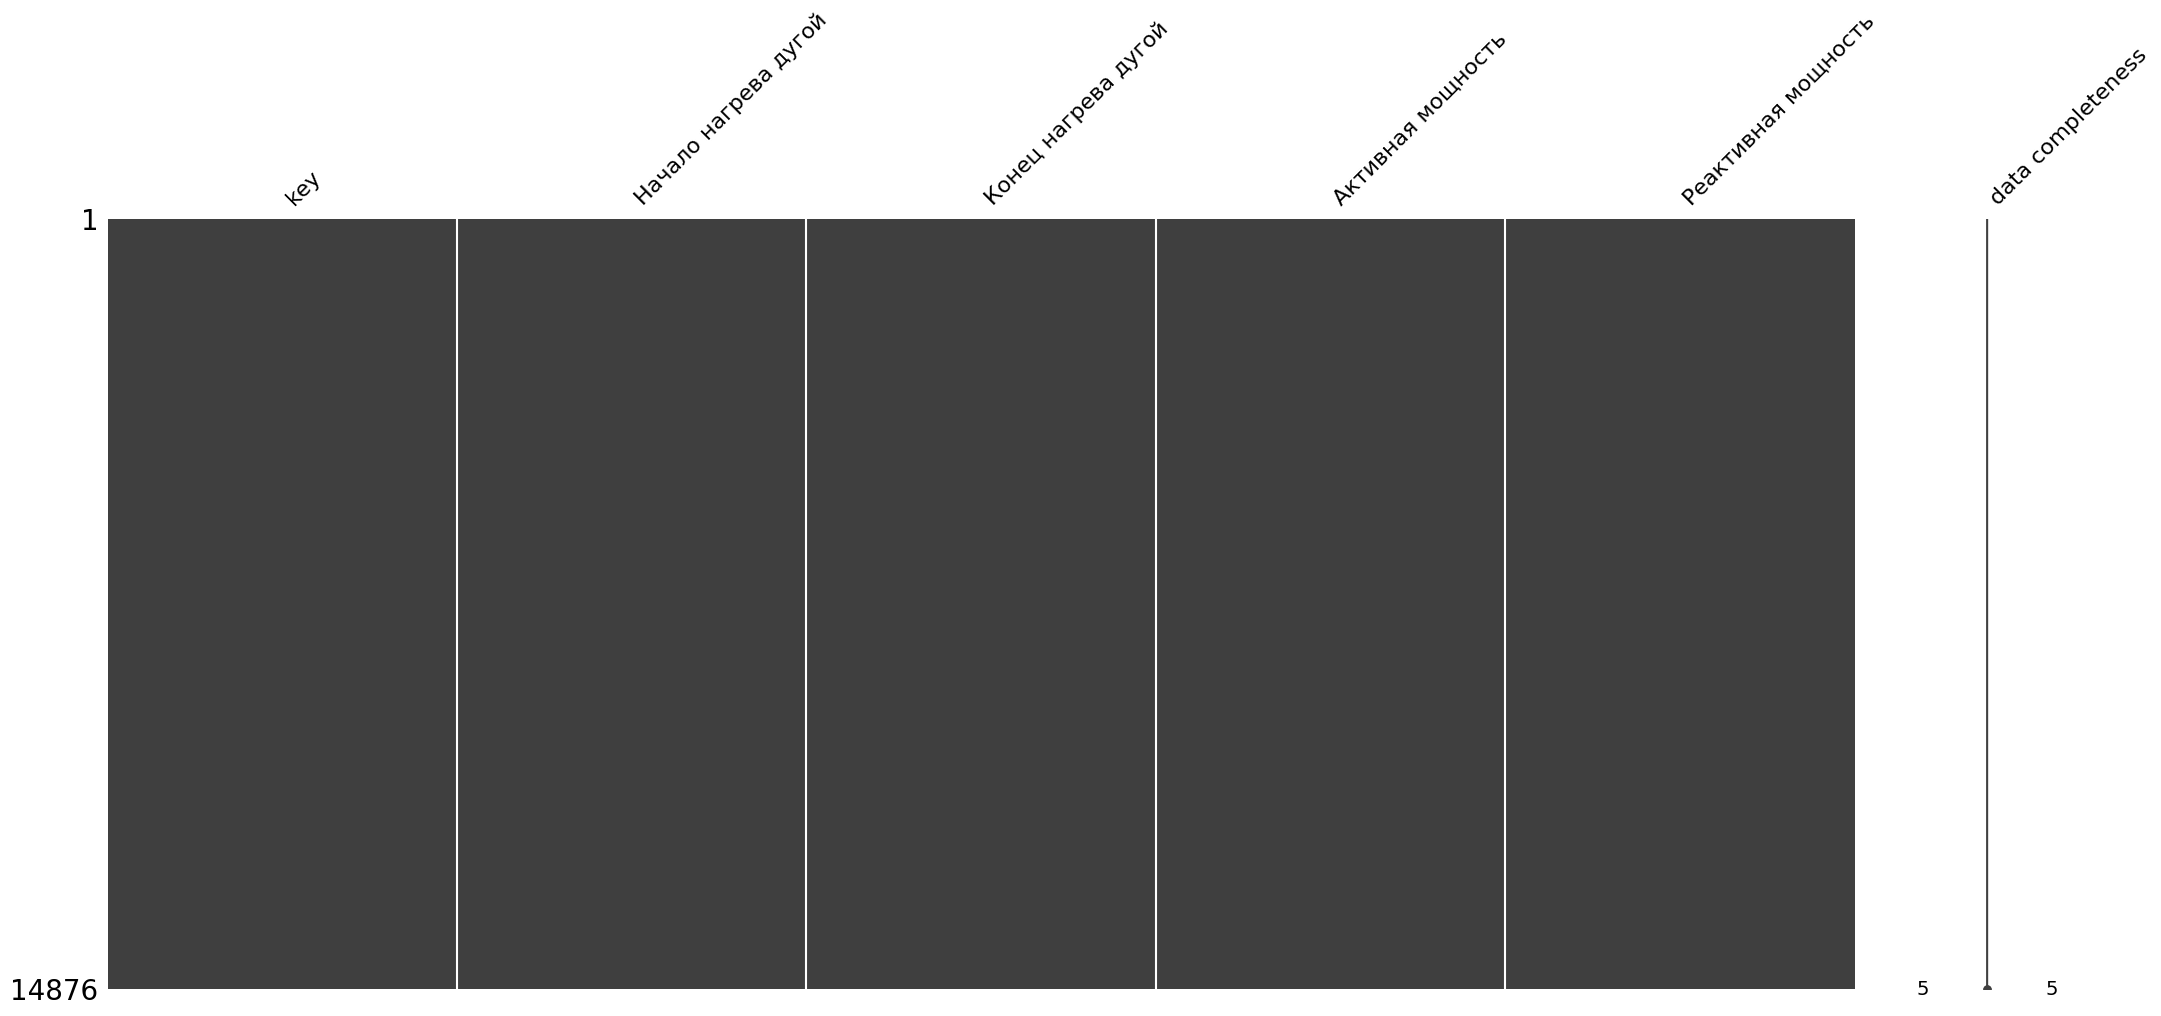

In [6]:
show_df_info(df_arc)

В данной таблице находятся данные о включении электродов для ковшей: время начала и время окончания нагрева, мощность активная и реактивная. Зная мощность и время можно найти общую энергию, выделенную при включении электродов.     
Всего записей - 14876  
Количество ковшей - 3241 ковш  
В таблице нет пропущенных значений, но имеется ряд вопросов:  
- Имеются отрицательные значения реактивной мощности (уточнить у заказчика, не ошибка ли это)
- Уточнить как что такое реактивная мощность (возможно, потери, необходимо ли их учитывать)
- Уточнить, как связана активная и реактивная мощности



### Изучим таблицу с данными о подаче сыпучих материалов (объём)

'Размер таблицы:'

(3129, 16)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


'Отобразим пропущенные значения на графике (для общего понимания объема пропущенных значений):'

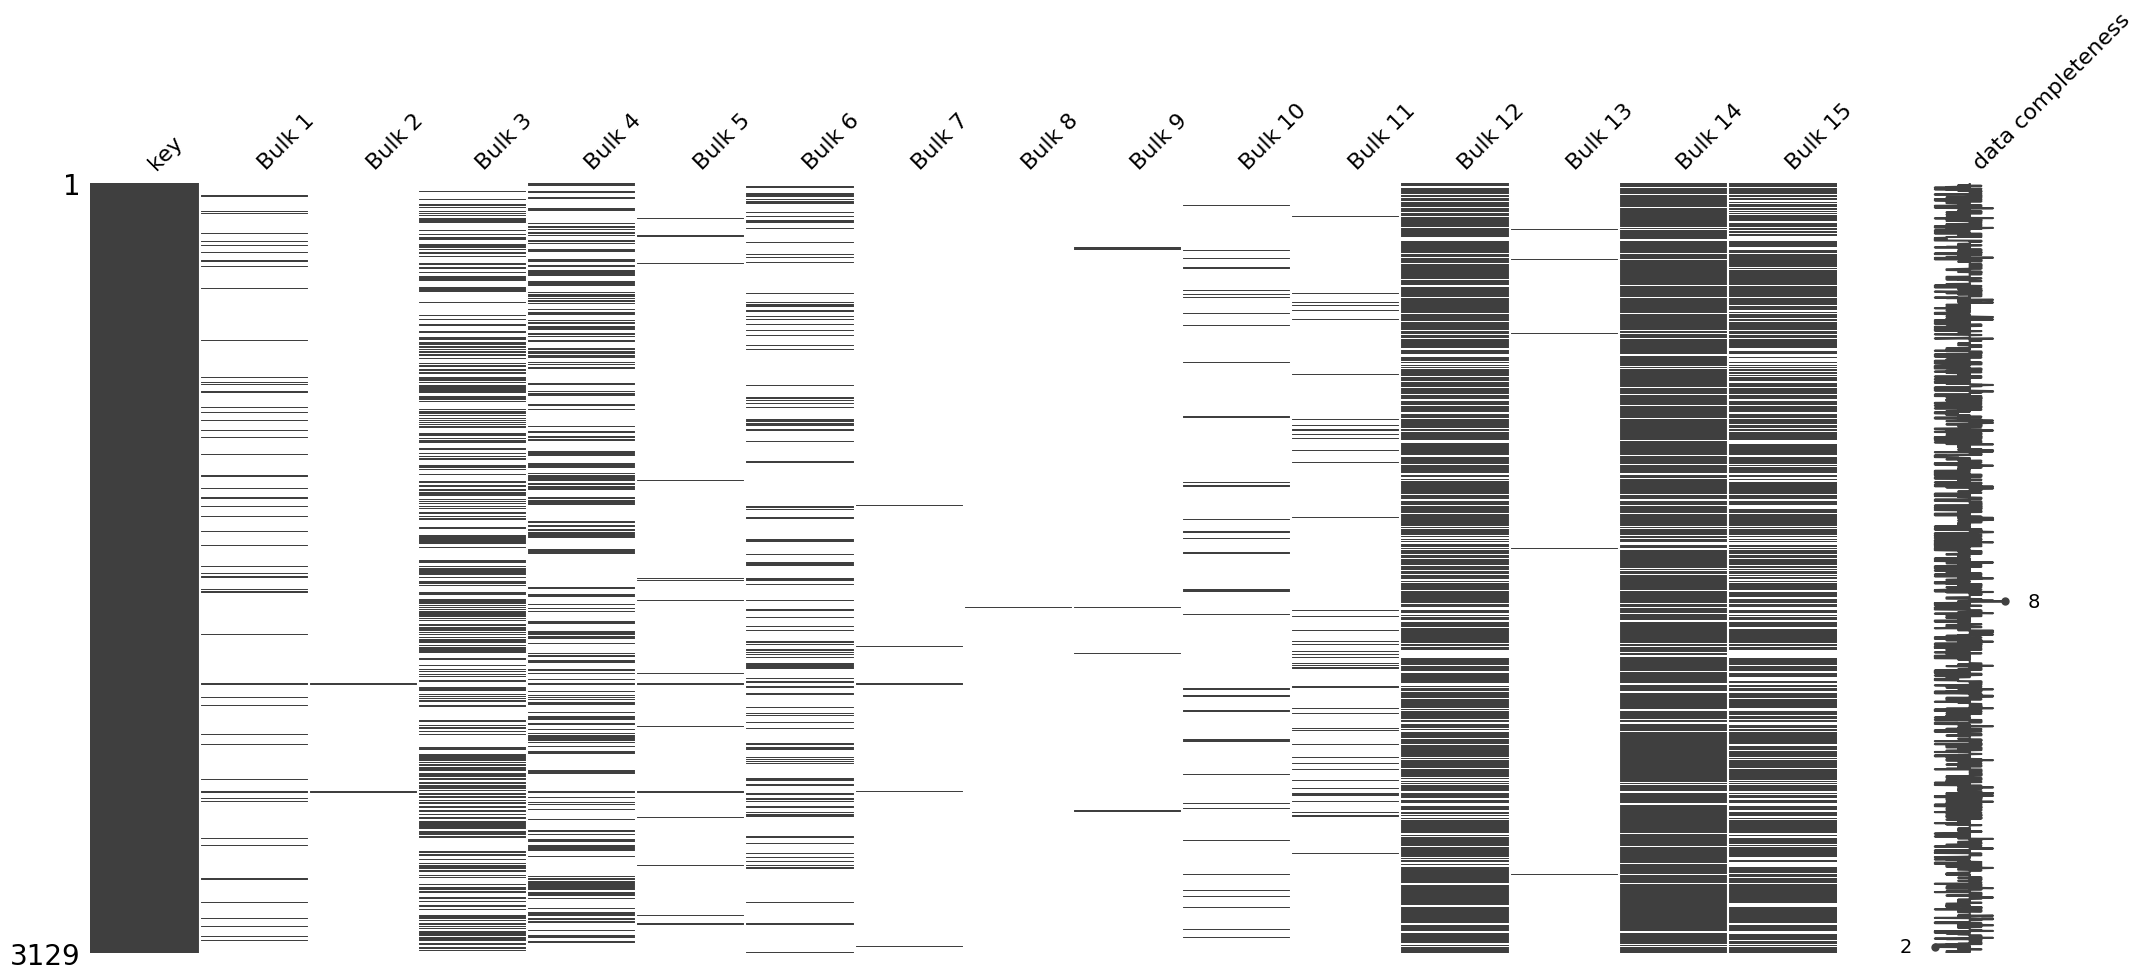

In [7]:
show_df_info(df_bulk)

В таблице приведены значения по объему сыпучих добавок.  
Как видно - какие-то применяются чаще, какие-то почти не применяются.  
Уточнить у заказчика на сколько критично включать в анализ редко используемые присадки.  
Пропущенные значения далее необходимо заменить нулямии.

### Данные о подаче сыпучих материалов (время)


'Размер таблицы:'

(3129, 16)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


'Отобразим пропущенные значения на графике (для общего понимания объема пропущенных значений):'

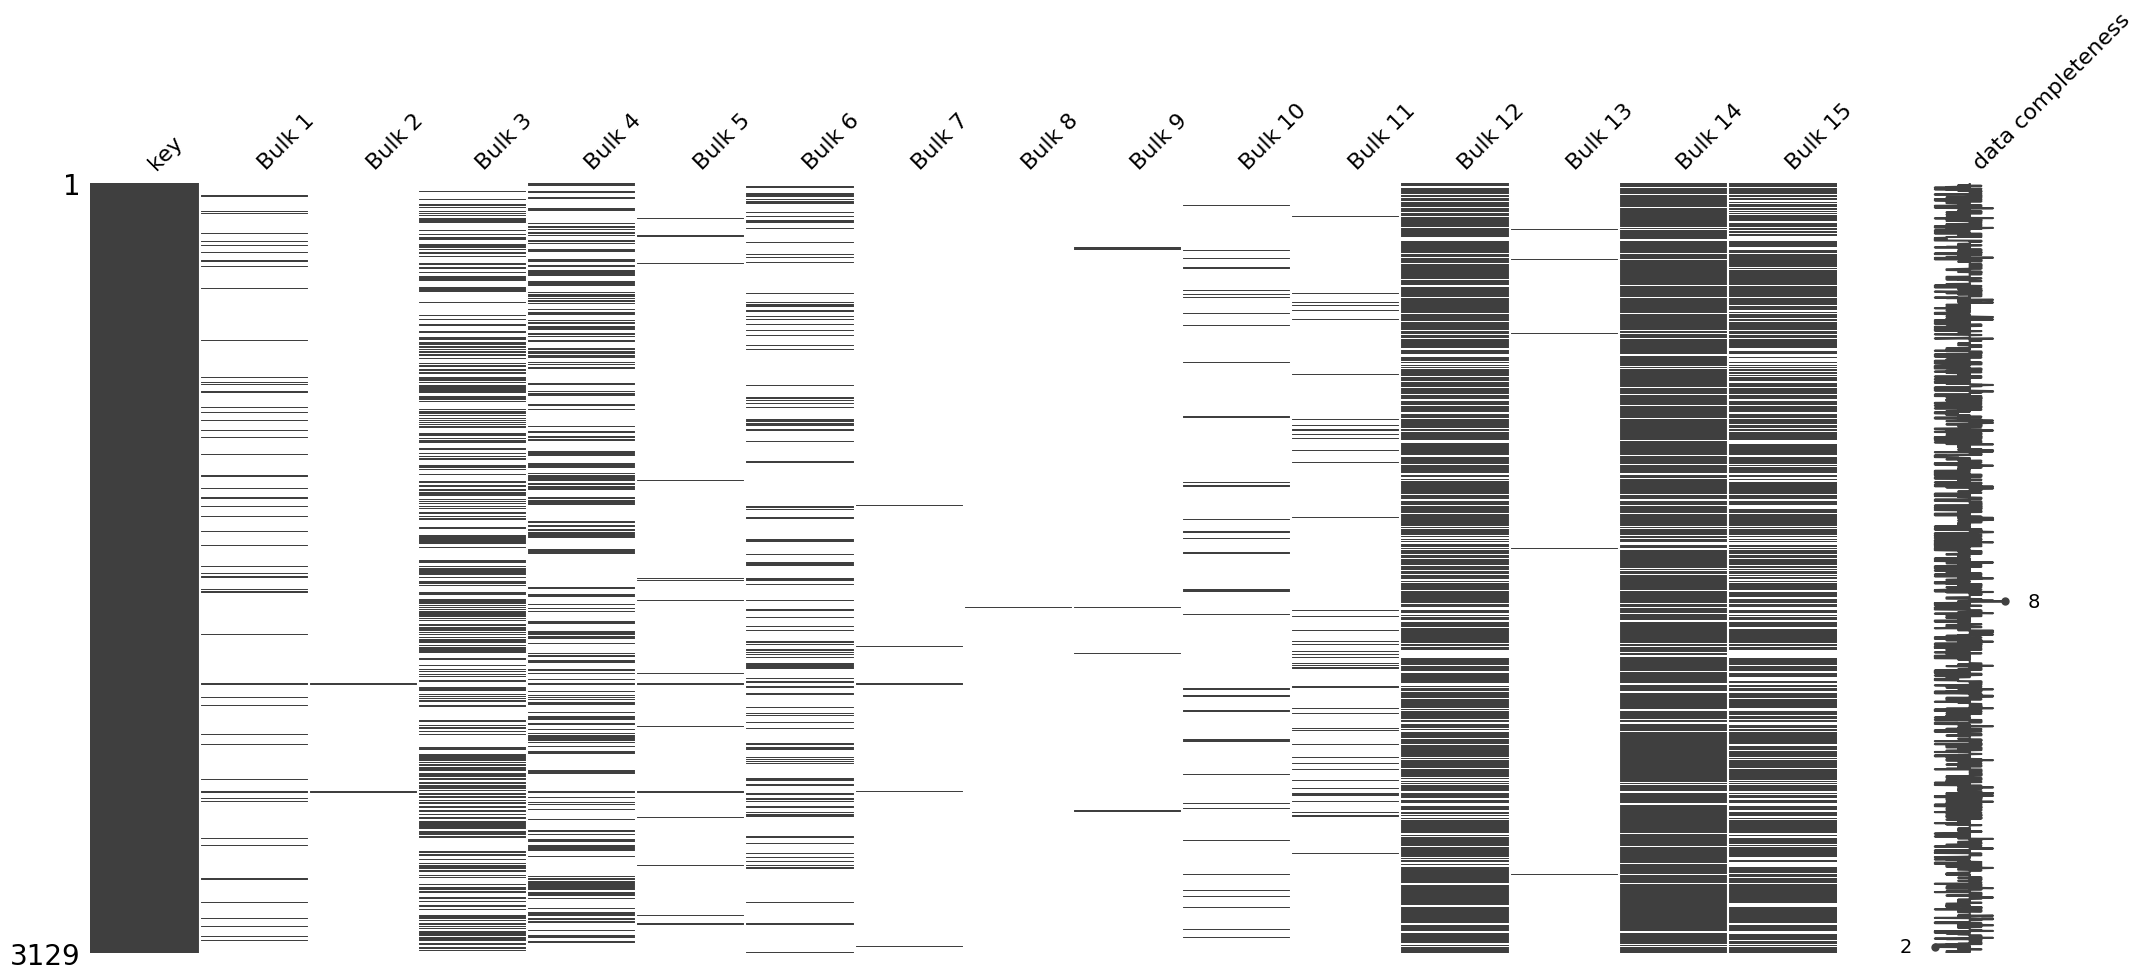

In [8]:
show_df_info(df_bulk_time)

В таблице имеются данные по времени подачи сыпучих материалов. Визуально, картина схожа с предыдущей таблицей - некоторые присадки практически не используются.

### Данные о продувке сплава газом


'Размер таблицы:'

(3239, 2)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


'Отобразим пропущенные значения на графике (для общего понимания объема пропущенных значений):'

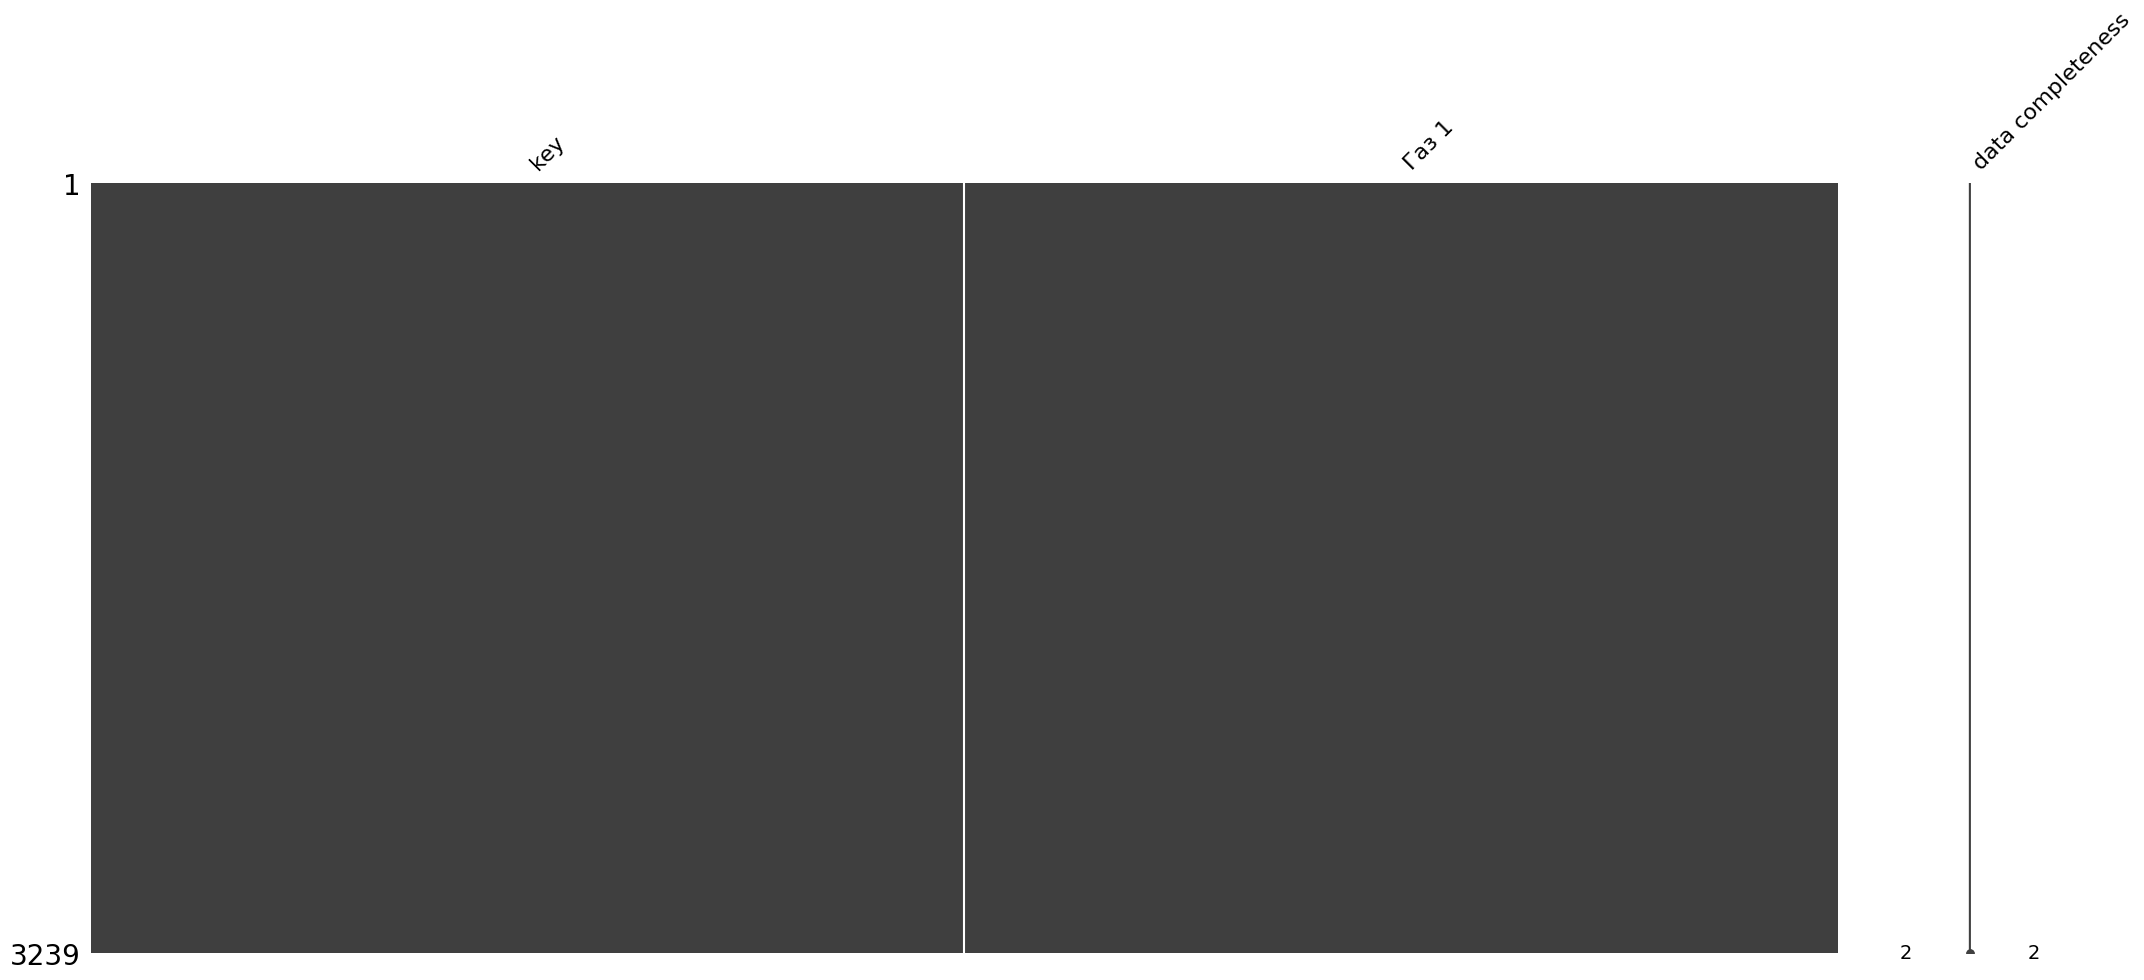

In [9]:
show_df_info(df_gas)

В таблице находятся данные по продувке сплава газом. Скорее всего - общее количество времени подачи газа для каждого ковша - эту информацию можно уточнить у заказчика.

### Результаты измерения температуры


'Размер таблицы:'

(18092, 3)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


'Отобразим пропущенные значения на графике (для общего понимания объема пропущенных значений):'

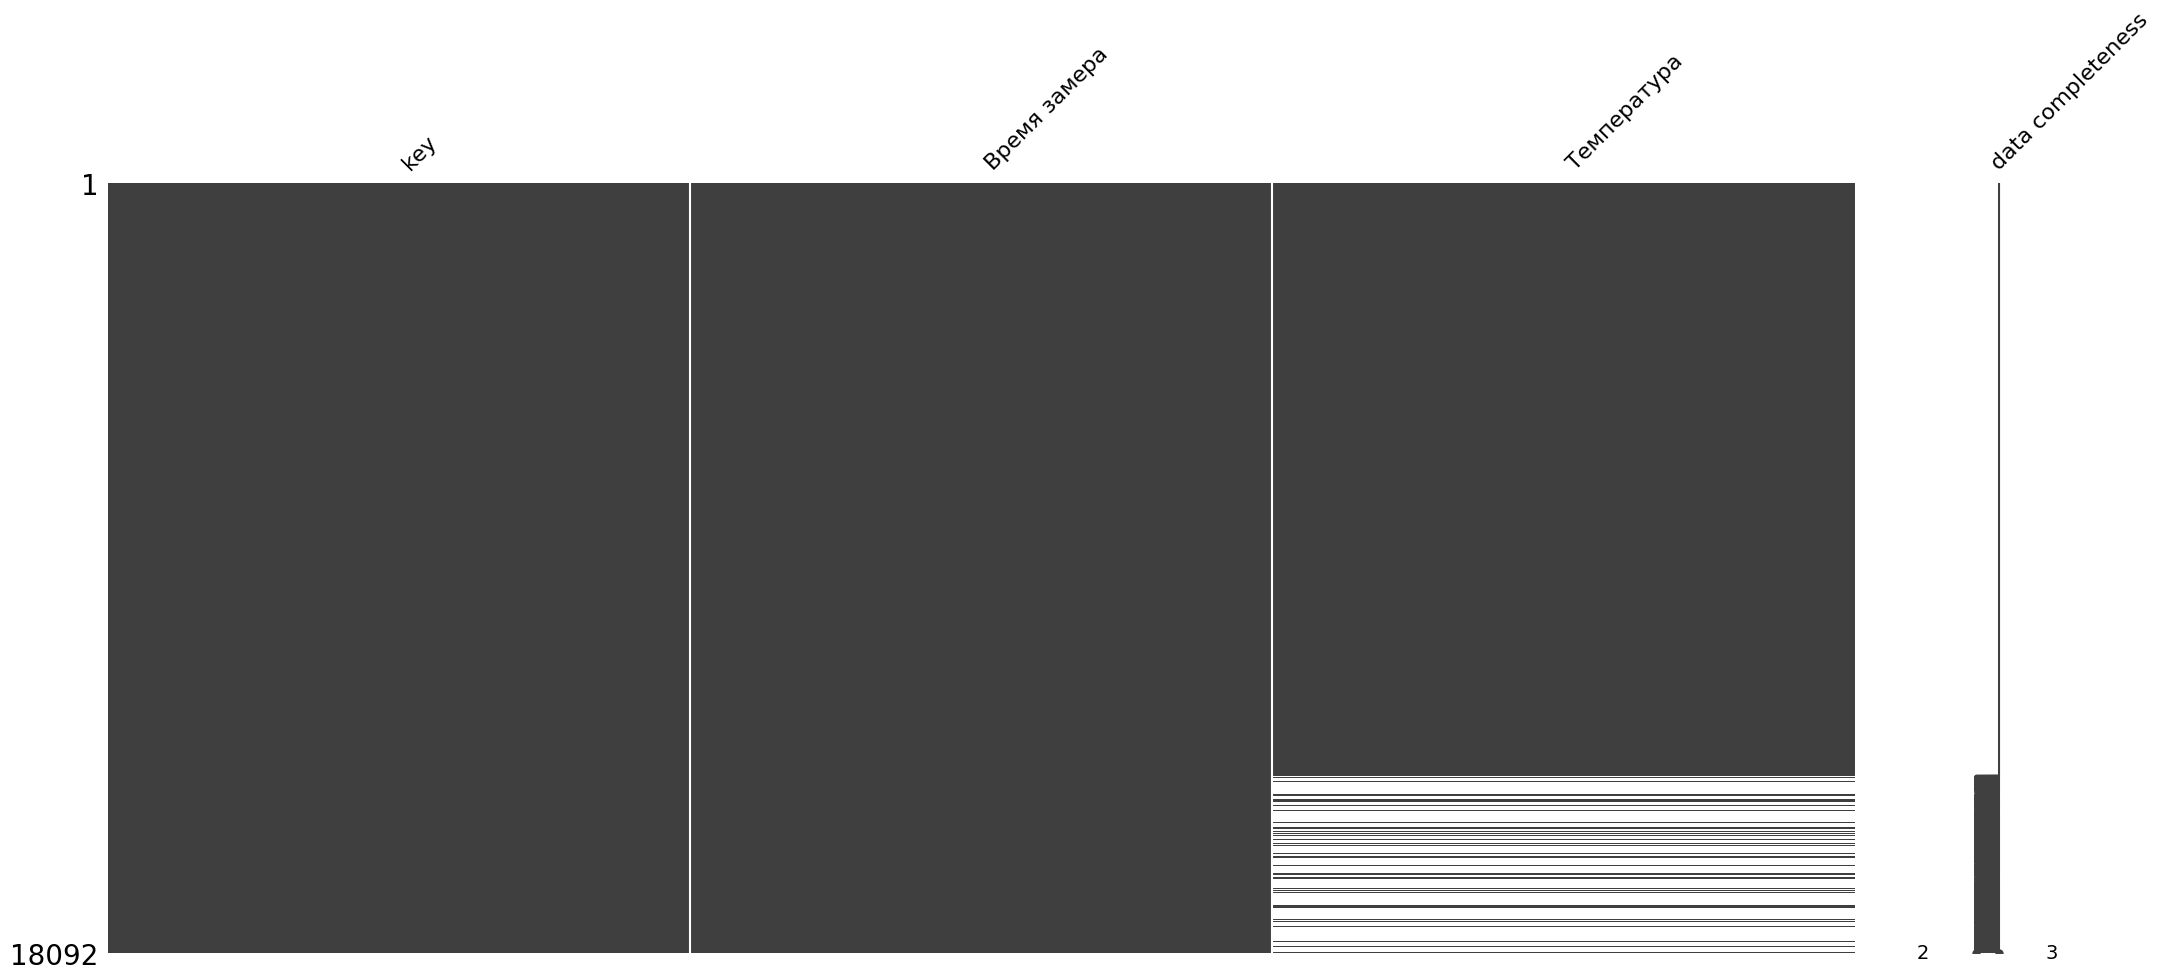

In [10]:
show_df_info(df_temp)

В таблице хранится информация о замерах температуры сплава в разное время - начальное, промежуточное (при тех.процессах) и конечное.  
Из таблицы - конечное время - целевой признак.  
В данных имеются значения температуры менее 1400 градусов - т.е. меньше температуры плавления стали. Возможно, неверные значения - надо будет удалить эти данные.
Из визуализации пропущенных значений видно, что имеется очень много пропусков при последних замерах - возможно, что-то случилось с датчиками температуры - необходимо предупредить об этом заказчика!

### Данные о проволочных материалах (объём)


'Размер таблицы:'

(3081, 10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


'Отобразим пропущенные значения на графике (для общего понимания объема пропущенных значений):'

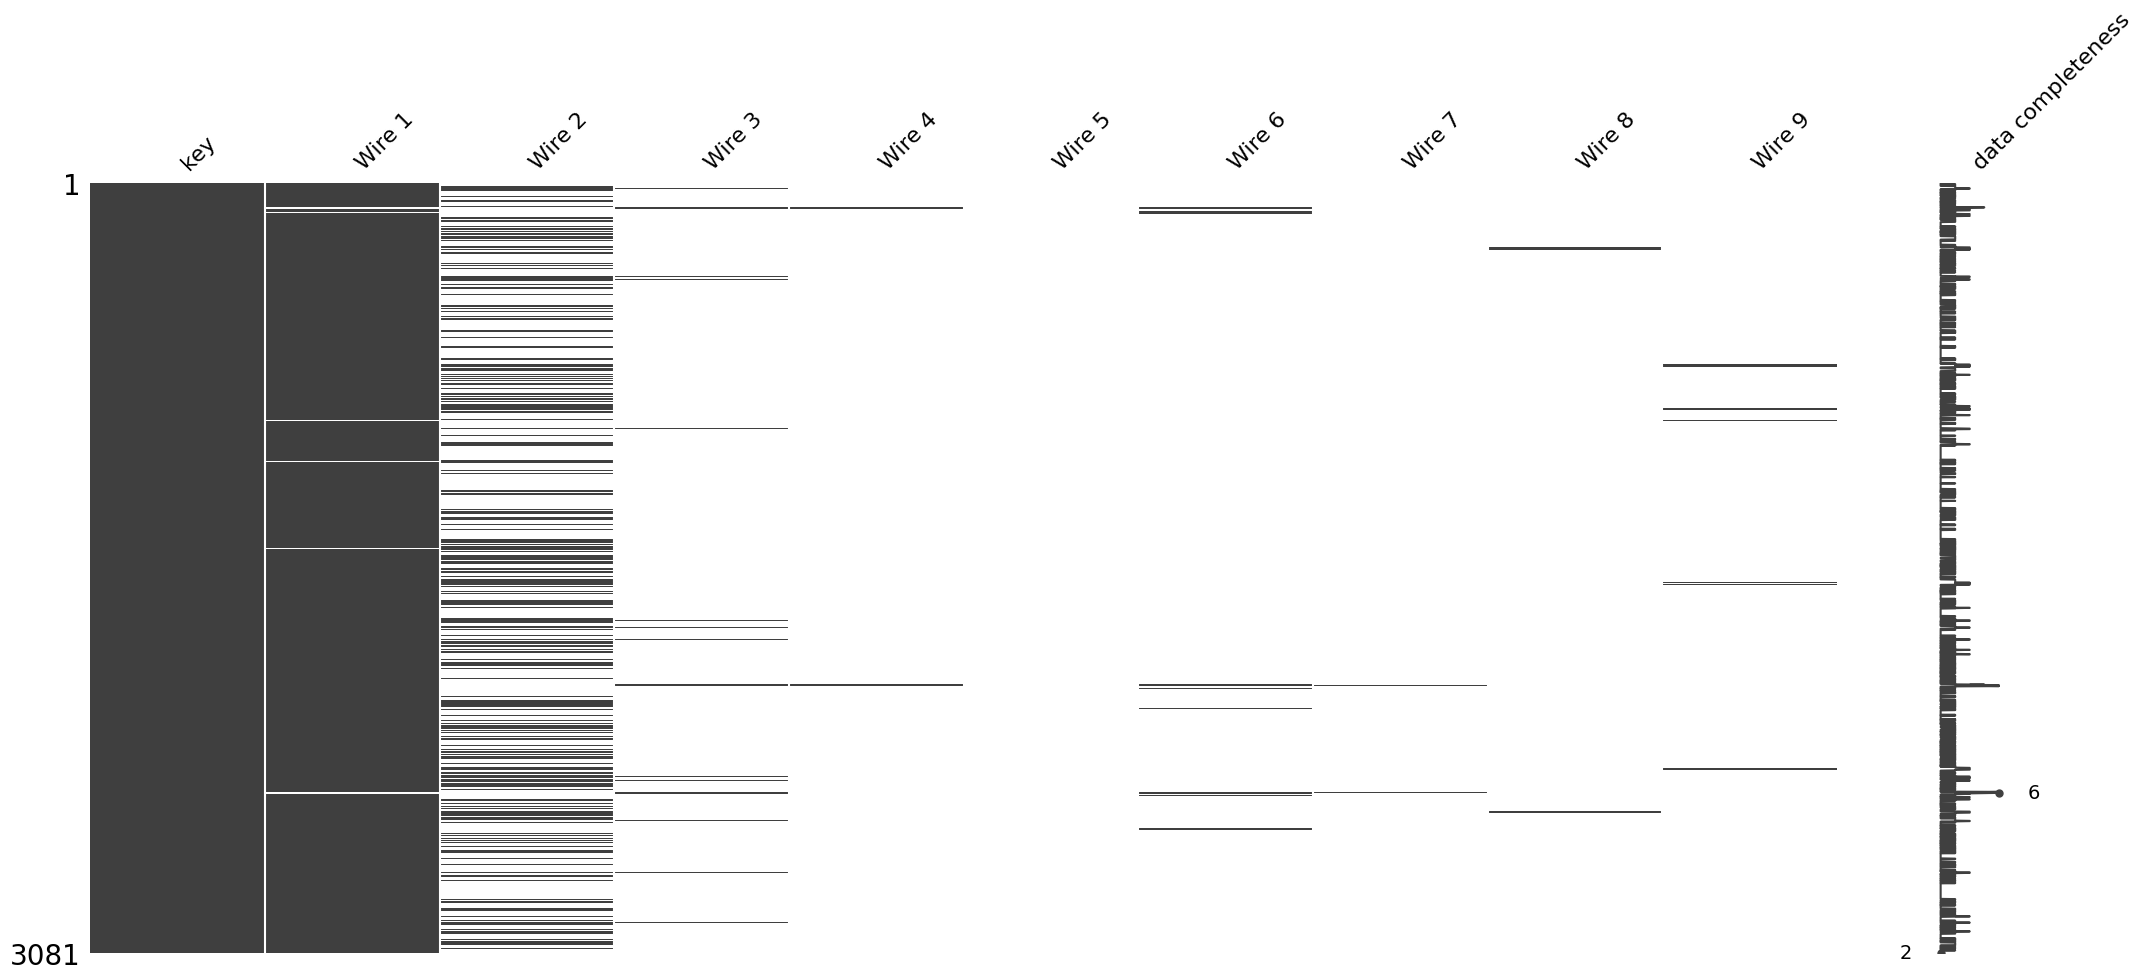

In [11]:
show_df_info(df_wire)

По сравнению с сыпучими материалами, проволочные применяются гораздо реже, чаще всего 2 вида.  
Уточнить у заказчика, на сколько критично учитывать редко используемые примеси.

### данные о проволочных материалах (время)

'Размер таблицы:'

(3081, 10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


'Отобразим пропущенные значения на графике (для общего понимания объема пропущенных значений):'

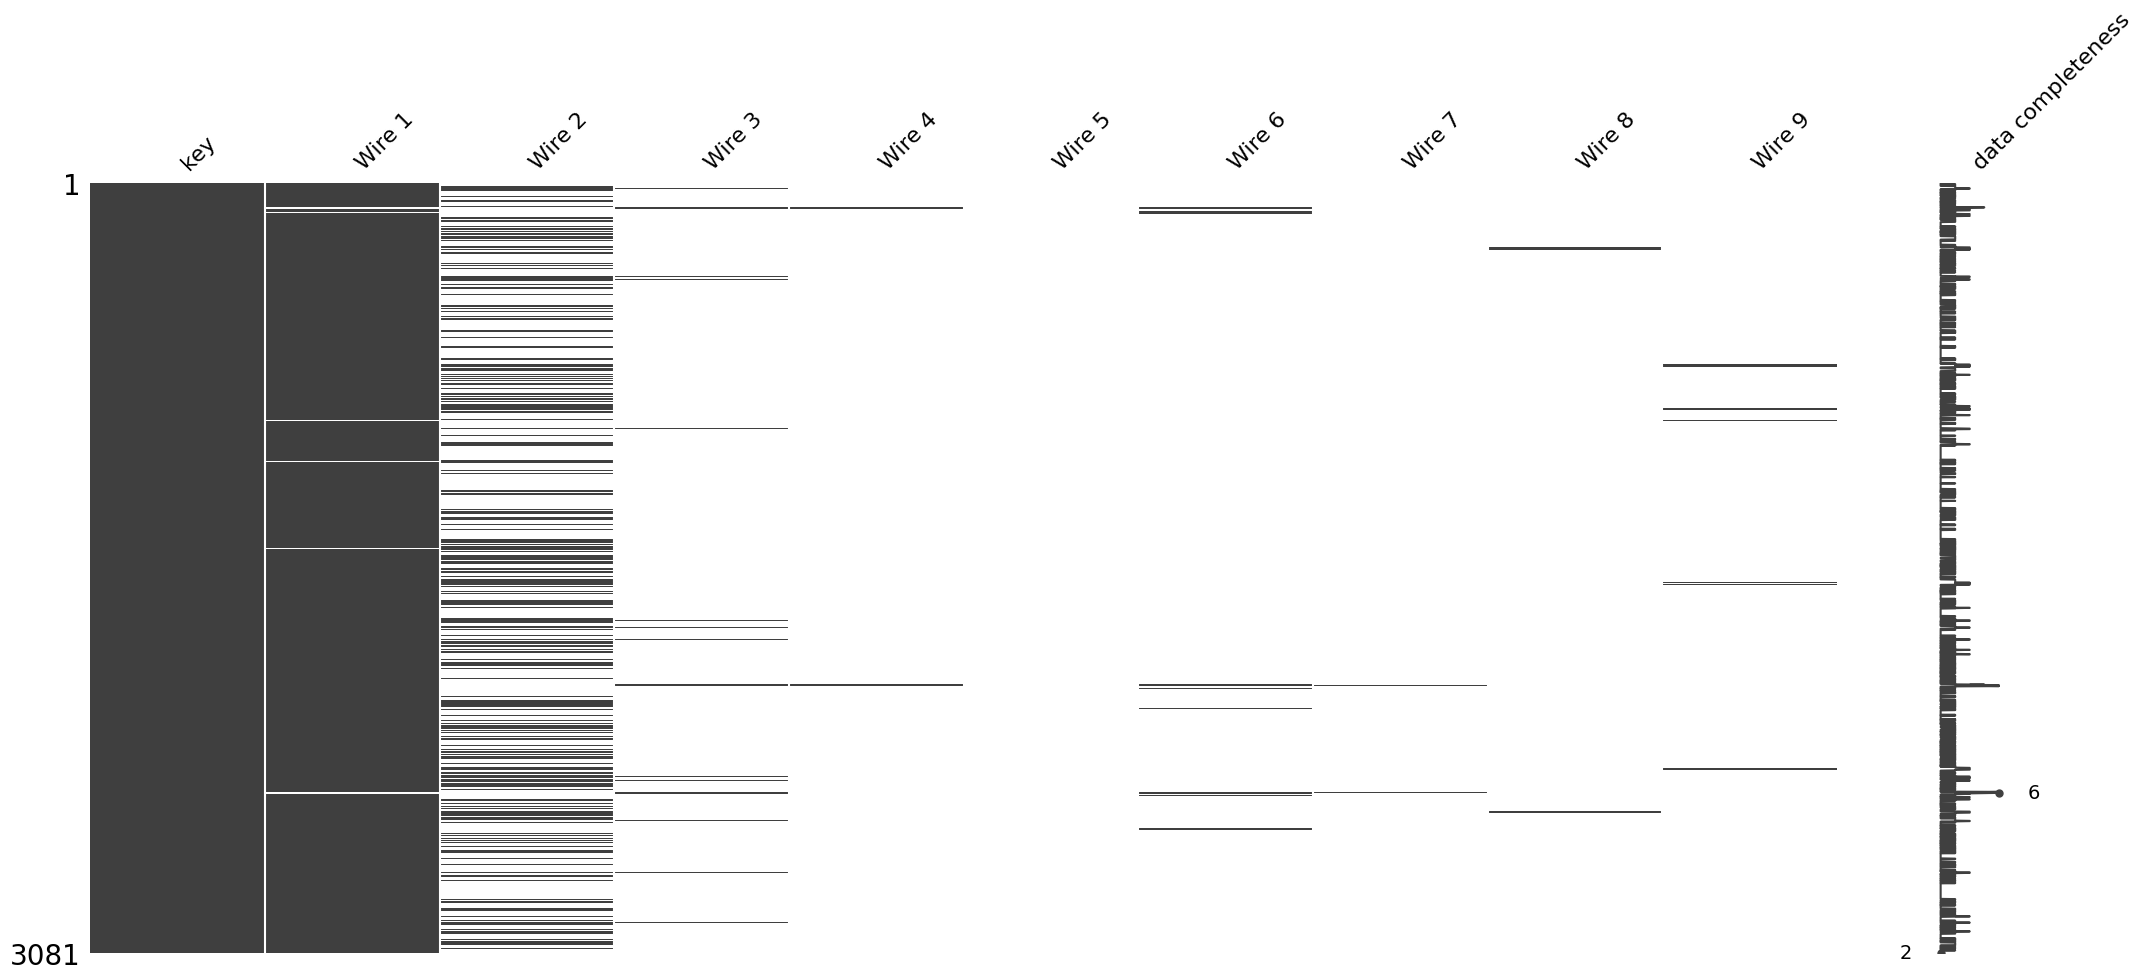

In [12]:
show_df_info(df_wire_time)

**ВЫВОД ПО АНАЛИЗУ ДАННЫХ**  
Информация по ковшам предоставлена в 7ми таблицах:  
- информация по замеряемой температуре сплава
- информация по нагреву сплава электродами
- информация по объему и времени подачи сыпучих и проволочных добавок
- информация по подаваемому газу в сплав

Данные структурированы, но требуют ряд пояснений от заказчика (см. ниже)

## План работы

1. Провести предобработку данных по каждой таблице:
- для таблиц с примесями заполнить отсутствующие значения нулями, возможно, удалить редко используемые примеси после согласования с заказчиком
- в таблице с замерами температуры - определить начальные и конечные замеры, удалить те данные ковшей, где отсутствуют начальные и/или конечные замеры температуры, а также те, где температура меньше 1400 градусов.
- в таблице по нагреву сплавов - удалить ошибочные данные с отрицательными значениями реактивной мощности, добавить информацию по общей мощности и затрачиваемой энергии.
2. Объединить таблицы в одну и проверить данные на коллинеарность
3. Обучить модель несколько моделеий, подобрать лучшую по кросс-валидации (**прошу выслать шпоргалку по этой теме**)
Хотя бы у одной из моделей подобрать параметры автоматически  
4. Проверить лучшую модель на тестовой выборке 0,25% - МАЕ должен быть меньше 6,8

### Дополнительные вопросы заказчику

1. Как связаны активная и реактивная мощности, какова общая мощность?
2. Имеются отрицательные значения реактивной мощности - необходимо подтверждение, что это ошибка и данные могут быть удалены
3. По примесям имеются редко используемые примеси - насколько критично будет не использовать их в модели
4. В таблице с информацией по газу имеются только значения по одному газу - уточнить, это общее время или объем газа при добавлении примесей.
5. Сообщить заказчику, что для последних ковшей очень часто имеются пропущенные значения замера температуры - возможно, необходимо проверить и заменить оборудование.

## Предобработка данных

###  Данные об электродах

In [13]:
#выведем 5 значений из таблицы об электродах
df_arc.head(5)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [14]:
df_arc.shape

(14876, 5)

In [15]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [16]:
# переименуем столбцы по правилам PEP8
# параметру columns передают словарь,
# в котором ключи — старые названия столбцов, а значения — новые

df_arc = df_arc.rename(
    columns={
        'Начало нагрева дугой':'start_heating',
        'Конец нагрева дугой': 'finish_heating',
        'Активная мощность': 'active_power',
        'Реактивная мощность': 'reactive_power',
    }
)

Переведем значения даты и время в соответствующий формат

In [17]:
df_arc['start_heating'] = pd.to_datetime(df_arc['start_heating'], format='%Y-%m-%dT%H:%M:%S')
df_arc['finish_heating'] = pd.to_datetime(df_arc['finish_heating'], format='%Y-%m-%dT%H:%M:%S')

**Удалим записи ковшей с отрицательной реактивной мощностью**

определим ковши, в которых встречается отричательная реактивная мощность

In [18]:
negative_reactive_power_keys = df_arc[df_arc['reactive_power'] < 0]['key'].tolist()
negative_reactive_power_keys

[2116]

In [19]:
df_arc.query('key in @negative_reactive_power_keys')['key'].count()

4

удалим эти значения из таблицы

In [20]:
df_arc = df_arc.query('key not in @negative_reactive_power_keys')

In [21]:
df_arc.shape

(14872, 5)

In [22]:
df_arc.head(2)

,key,start_heating,finish_heating,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438


**Посчитаем полную мощность и добавим в новый столбец**

Полная мощность высчитывается по следующей формуле:  

$S = \sqrt{Q^2 + P^2} $

где P — активная мощность, Q — реактивная мощность

In [23]:
df_arc['full_power'] = (df_arc['active_power']**2 + df_arc['reactive_power']**2)**0.5

Добавим информацию по времени нагрева

In [24]:
df_arc['heating_time'] = (df_arc['finish_heating'] - df_arc['start_heating']).dt.seconds

In [25]:
# добавим столбец с полной энергией
df_arc['energy'] = df_arc['full_power'] * df_arc['heating_time']

In [26]:
df_arc.head(2)

,key,start_heating,finish_heating,active_power,reactive_power,full_power,heating_time,energy
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,228,84.616003
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,185,166.928978


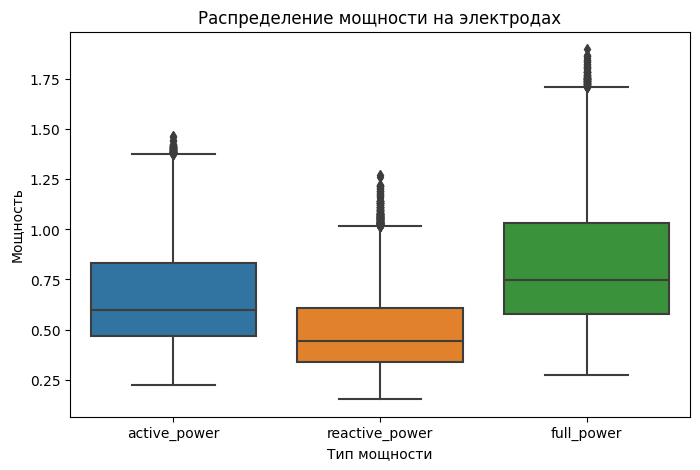

In [27]:
# построим графики распределения мощностей
f, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=df_arc.iloc[:,1:-2])
plt.xlabel('Тип мощности')
plt.ylabel('Мощность')
plt.title('Распределение мощности на электродах');

Объединим данные в таблице по ключам ковшей и сохраним данные по сумме значения энергии, мощностей, времени нагревания, а также посчитаем количество циклов включения нагрева.

In [28]:
df_arc = df_arc.pivot_table(
    index='key', 
    values=['active_power', 'reactive_power', 'full_power', 'heating_time', 'energy', 'start_heating'], 
    aggfunc={'active_power': 'sum', 
             'reactive_power': 'sum', 
             'full_power': 'sum', 
             'heating_time': 'sum', 
             'energy': 'sum',
             'start_heating' : 'count'
            },
).reset_index()

In [29]:
df_arc = df_arc.rename(
    columns={
        'start_heating':'number_of_heating'
    }
)

In [30]:
df_arc.head()

,key,active_power,energy,full_power,heating_time,reactive_power,number_of_heating
0,1,3.036730,770.282114,3.718736,1098,2.142821,5
1,2,2.139408,481.760005,2.588349,811,1.453357,4
2,3,4.063641,722.837668,5.019223,655,2.937457,5
3,4,2.706489,683.455597,3.400038,741,2.056992,4
4,5,2.252950,512.169934,2.816980,869,1.687991,4


In [31]:
df_arc.shape

(3213, 7)

**Вывод**: Провели предобработку в таблице с данными по электродам:  
- удалили ковши с отричательным значением реактивной мощности (1 ковш - 4 строки)  
- добавили столбец с полной мощностью, временем нагрева и энергией
- сгрупировали данные по ключу ковша и оставили данные по сумме мощностей, энергии, времени нагрева, а также добавили количество нагревов

### Данные о подаче сыпучих материалов (объём)

In [32]:
#выведем 5 значений из таблицы об электродах
df_bulk.head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [33]:
df_bulk.shape

(3129, 16)

In [34]:
df_bulk.columns = df_bulk.columns.str.lower().str.replace(' ', '_')
df_bulk.columns

Index(['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15'],
      dtype='object')

In [35]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Удалим столбец с данными по добавке №8, которая встречается в данных только 1 раз

In [36]:
df_bulk = df_bulk.drop(['bulk_8'], axis=1)

In [37]:
# Проверим количество пропущенных значение:
df_bulk.isna().sum()

key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7     3104
bulk_9     3110
bulk_10    2953
bulk_11    2952
bulk_12     679
bulk_13    3111
bulk_14     323
bulk_15     881
dtype: int64

 Отсутствие данных по подаче сыпучих материалов свидетельствует, что их не применяли - заполним эти значения нулями

In [38]:
df_bulk = df_bulk.fillna(0)
df_bulk.head(2)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0


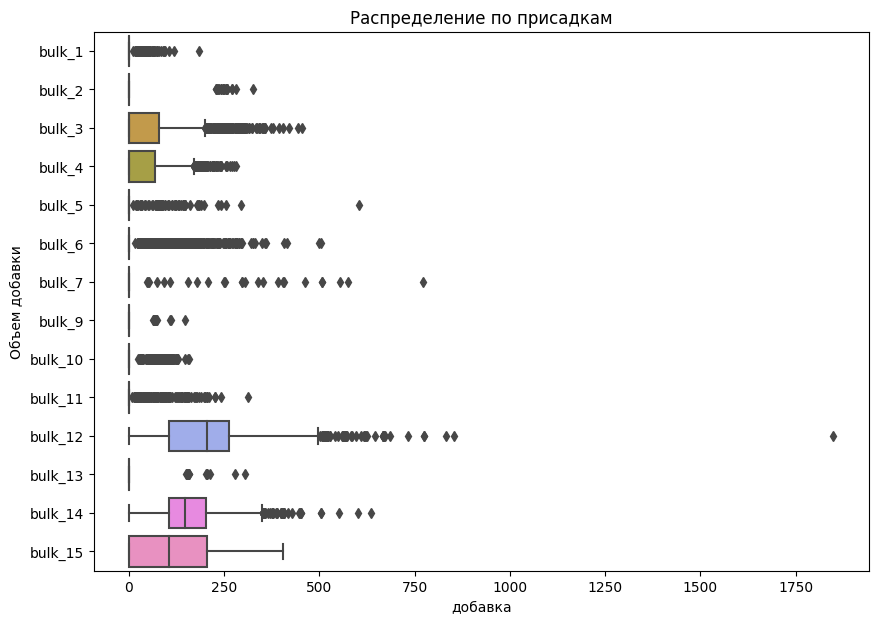

In [39]:
# построим графики распределения
f, ax = plt.subplots(figsize=(10, 7))
sns.boxplot(data=df_bulk.iloc[:,1:], orient='h')
plt.title('Распределение по присадкам')
plt.xlabel('добавка')
plt.ylabel('Объем добавки');


**Вывод**: Провели предобработку в таблице с данными по объему сыпучих материалов:  
- привели названия столбцов к нормам PEP8
- заполнили пустые значения нулями

### Данные о подаче сыпучих материалов (время)

In [40]:
#выведем 5 значений из таблицы об электродах
df_bulk_time.head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


Данная таблица хранит информацию по времени подачи материала - для нас эти данные излишни.  
Учитывать информацию из этой таблицы не будем.

### Данные о продувке сплава газом

In [41]:
df_gas.head(5)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [42]:
df_gas.shape

(3239, 2)

In [43]:
# Проверим количество пропущенных значение:
df_gas.isna().sum()

key      0
Газ 1    0
dtype: int64

In [44]:
df_gas = df_gas.rename(
    columns={
        'Газ 1':'gas_1'
    }
)

In [45]:
df_gas.head(2)

,key,gas_1
0,1,29.749986
1,2,12.555561


**Вывод:** В данных пропусков и проблем нет.

### Результаты измерения температуры

In [46]:
df_temp.head(5)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [47]:
df_temp.shape

(18092, 3)

In [48]:
df_temp = df_temp.rename(
    columns={
        'Время замера':'measuring_time',
        'Температура': 'temperature'
    }
)

In [49]:
df_temp['measuring_time'] = pd.to_datetime(df_temp['measuring_time'], format='%Y-%m-%dT%H:%M:%S')

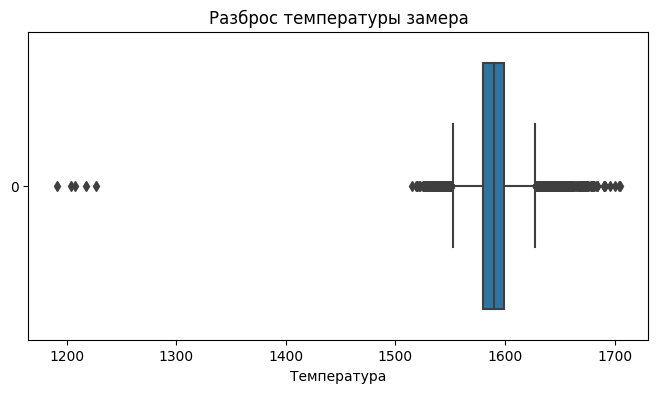

In [50]:
# построим графики распределения
f, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(data=df_temp['temperature'], orient='h')
plt.title('Разброс температуры замера')
plt.xlabel('Температура');

In [51]:
df_temp[df_temp['temperature'] < 1500]

,key,measuring_time,temperature
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


In [52]:
df_temp.query('key == 867')

,key,measuring_time,temperature
4883,867,2019-06-06 08:03:39,1191.0
4884,867,2019-06-06 08:18:52,1575.0
4885,867,2019-06-06 08:22:38,1576.0
4886,867,2019-06-06 08:25:11,1571.0
4887,867,2019-06-06 08:29:49,1600.0
4888,867,2019-06-06 08:36:49,1522.0
4889,867,2019-06-06 08:43:02,1521.0
4890,867,2019-06-06 08:48:23,1599.0


В таблице имеются значения замеров температуры, которые меньше температуры плавления стали 1400 градусов. Необходимо будет удалить все вхождения с данными ключами.  Удалим те из них, у которых температура меньше 1450 градусов. Для начала запишем ключи таких температур в отдельную переменную defective_keys

In [53]:
defective_keys = df_temp[df_temp['temperature'] < 1450]['key'].tolist()
defective_keys

[867, 1214, 1619, 2052, 2561]

Также необходимо будет удалить ковши с пропущенными значениями замера температуры

In [54]:
defective_keys += df_temp[df_temp['temperature'].isna()]['key'].unique().tolist()

Выявим ковши с одним замером - их тоже необходимо удалить из таблицы

In [55]:
measurements_quantity = df_temp.pivot_table(index='key', values=['temperature'] ,aggfunc='count').reset_index()

In [56]:
defective_keys += measurements_quantity[measurements_quantity['temperature'] < 2 ]['key'].tolist()

In [57]:
len(defective_keys)

1485

Удалим ненужные данные

In [58]:
df_temp = df_temp.query('key not in @defective_keys')

In [59]:
df_temp.shape

(13903, 3)

Теперь возьмем начальную и конечную температуры замеров.

In [60]:
df_temp.head()

,key,measuring_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [61]:
df_temp.sort_values(by='measuring_time')

,key,measuring_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
13921,2499,2019-08-10 13:33:21,1569.0
13922,2499,2019-08-10 13:41:34,1604.0
13923,2499,2019-08-10 13:46:28,1593.0
13924,2499,2019-08-10 13:54:56,1588.0


In [62]:
df_temp = df_temp.sort_values(by='measuring_time')\
    .pivot_table(index='key', values=['temperature'], aggfunc=['first', 'last']).reset_index()

In [63]:
df_temp.columns = ['key', 'first_temperture', 'last_temperature']

In [64]:
df_temp.head(5)

,key,first_temperture,last_temperature
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0


In [65]:
df_temp.shape

(2471, 3)

**Вывод:**  
В таблице с данными по замерам температуры мы удалили данные о ковшах для следующих случаев:  
- имеются температуры менее температуры плавления стали 1450 градусов
- имеются пропущенные значения в замерах температуры
- сделан всего 1 замер температуры  

В таблице оставили значения первого замера и последнего замера

### Данные о проволочных материалах (объём)

In [66]:
#выведем 5 значений из таблицы об электродах
df_wire.head(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
df_wire.shape

(3081, 10)

In [68]:
df_wire.columns = df_wire.columns.str.lower().str.replace(' ', '_')
df_wire.columns

Index(['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9'],
      dtype='object')

In [69]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Удалим столбец с данными по добавке №5, которая встречается в данных только 1 раз

In [70]:
df_wire = df_wire.drop(['wire_5'], axis=1)

Заполним пропущенные значения нулями

In [71]:
df_wire = df_wire.fillna(0)
df_wire.head(2)

,key,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0


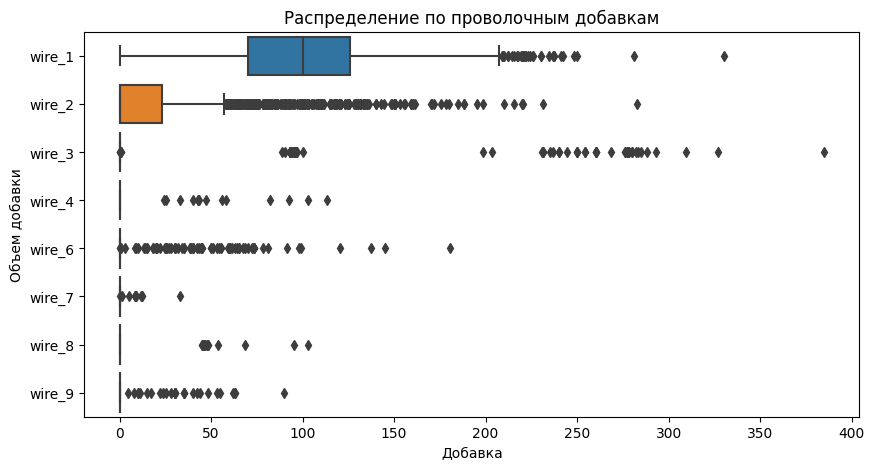

In [72]:
# построим графики распределения
f, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df_wire.iloc[:,1:], orient='h')
plt.title('Распределение по проволочным добавкам')
plt.xlabel('Добавка')
plt.ylabel('Объем добавки');

**Вывод**: Провели предобработку в таблице с данными по объему сыпучих материалов:  
- привели названия столбцов к нормам PEP8
- заполнили пустые значения нулями  
- удалили столбец с добавкой, которая встречается только 1 раз

### Данные о проволочных материалах (время)

In [73]:
#выведем 5 значений из таблицы об электродах
df_wire_time.head(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Данная таблица хранит информацию по времени подачи материала - для предсказания эти данные излишни.  
Учитывать информацию из этой таблицы не будем.

## Объединение таблиц

Итак, у нас остались 5 таблиц, которые необходимо объединить:  
- Данные об электродах - df_arc  
- Данные о сыпучих материалах (объем) - df_bulk
- Данные о проволочных материалах (объем) - df_wire
- Данные о продувке газом - df_gas
- Данные об измерении температуры - df_temp  

Объединим эти таблицы по ключу ковша 'key'. Если какая-то из таблиц не будет иметь ключа - то эти ковшы не будут использоваться в обучении модели.


In [74]:
df_merged = df_arc.merge(df_bulk, on='key', how='inner')
df_merged = df_merged.merge(df_gas, on='key', how='inner')
df_merged = df_merged.merge(df_temp, on='key', how='inner')
df_merged = df_merged.merge(df_wire, on='key', how='inner')

In [75]:
df_merged.head()

,key,active_power,energy,full_power,heating_time,reactive_power,number_of_heating,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas_1,first_temperture,last_temperature,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
0,1,3.036730,770.282114,3.718736,1098,2.142821,5,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,1571.0,1613.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2.139408,481.760005,2.588349,811,1.453357,4,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,1581.0,1602.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,4.063641,722.837668,5.019223,655,2.937457,5,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,1596.0,1599.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2.706489,683.455597,3.400038,741,2.056992,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,1601.0,1625.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2.252950,512.169934,2.816980,869,1.687991,4,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,1576.0,1602.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
df_merged.shape

(2324, 32)

In [77]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2324 non-null   int64  
 1   active_power       2324 non-null   float64
 2   energy             2324 non-null   float64
 3   full_power         2324 non-null   float64
 4   heating_time       2324 non-null   int64  
 5   reactive_power     2324 non-null   float64
 6   number_of_heating  2324 non-null   int64  
 7   bulk_1             2324 non-null   float64
 8   bulk_2             2324 non-null   float64
 9   bulk_3             2324 non-null   float64
 10  bulk_4             2324 non-null   float64
 11  bulk_5             2324 non-null   float64
 12  bulk_6             2324 non-null   float64
 13  bulk_7             2324 non-null   float64
 14  bulk_9             2324 non-null   float64
 15  bulk_10            2324 non-null   float64
 16  bulk_11            2324 

Удалим столбец со значением ключа - он нам теперь не понадобится.

In [78]:
df_merged = df_merged.drop(['key'], axis=1)

###  Проверим данные на корреляцию

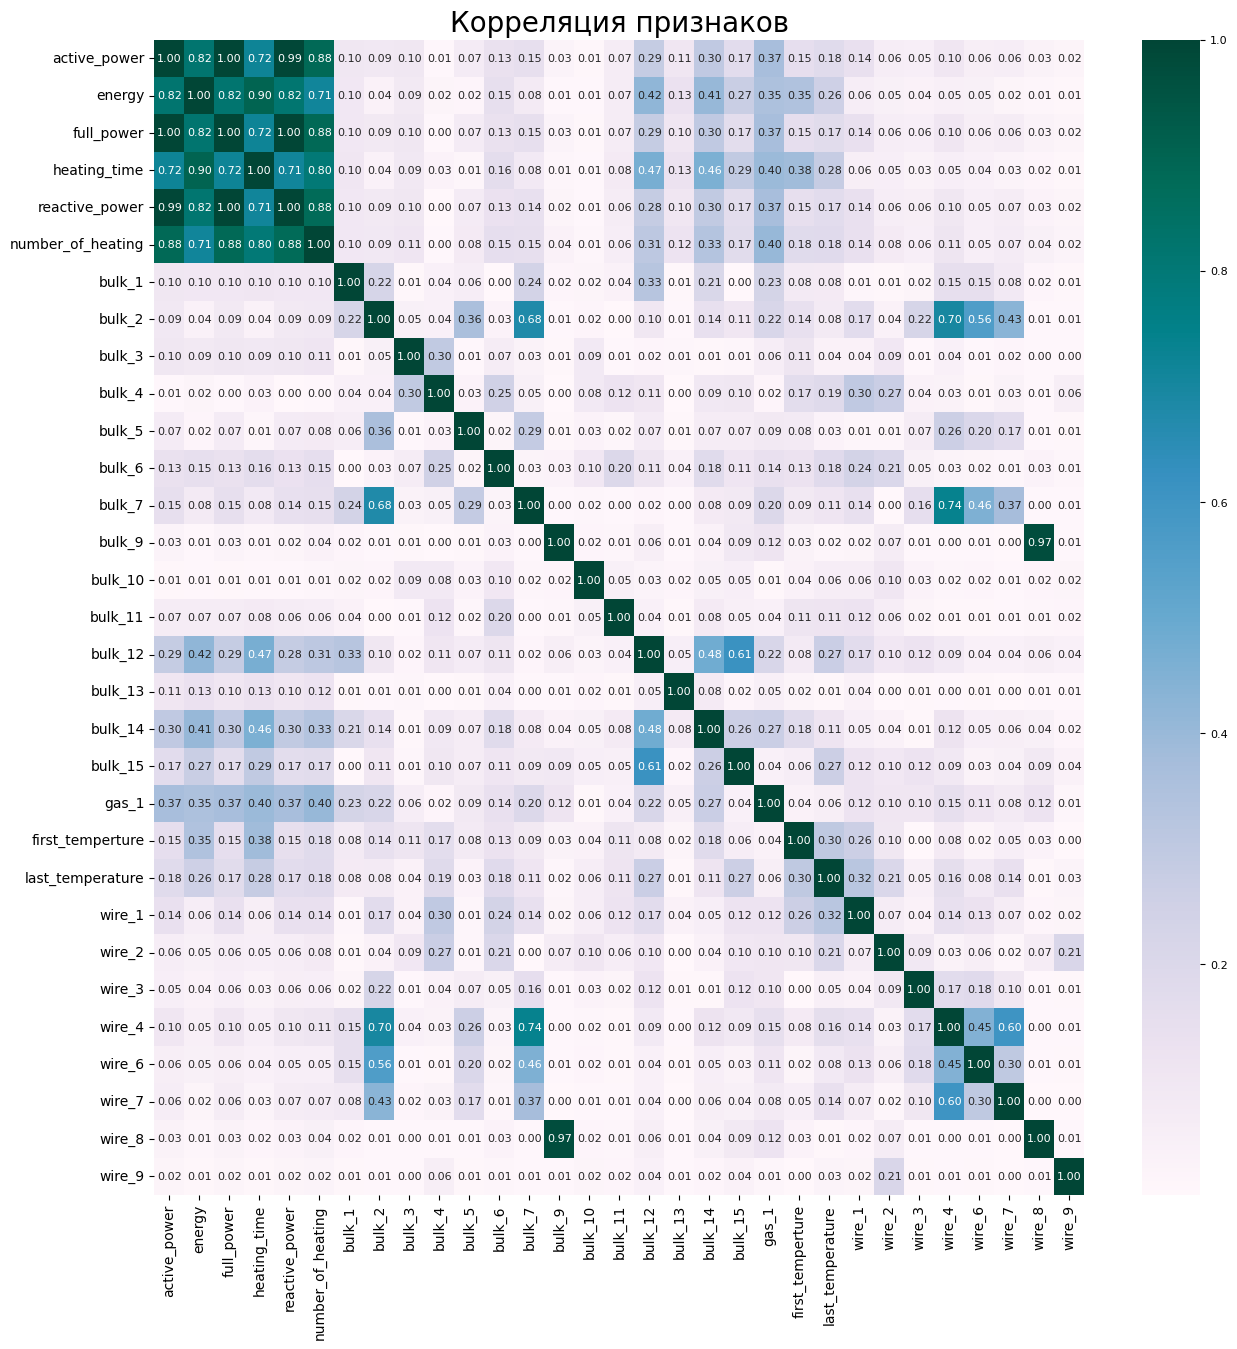

In [79]:
plt.figure(figsize=(15, 15))
plt.title('Корреляция признаков', fontsize=20)
plt.rcParams.update({'font.size': 8})
sns.heatmap(df_merged.corr().abs(), annot = True, cmap='PuBuGn', fmt ='.2f')

plt.show()

Как видно из талицы корреляции, зависимые параметры - реактивная мощность, время нагрева, полная мощность, активная мощность. А также зависимость с сыпучей добавки №9 и проволочной №8 (видимо, добавляют их одновременно).  
Удалим лишние столбцы, для которых коэффициент корреляции больше 0,9.

In [80]:
df_merged = df_merged.drop(['active_power', 'heating_time', 'wire_8', 'reactive_power'], axis=1)

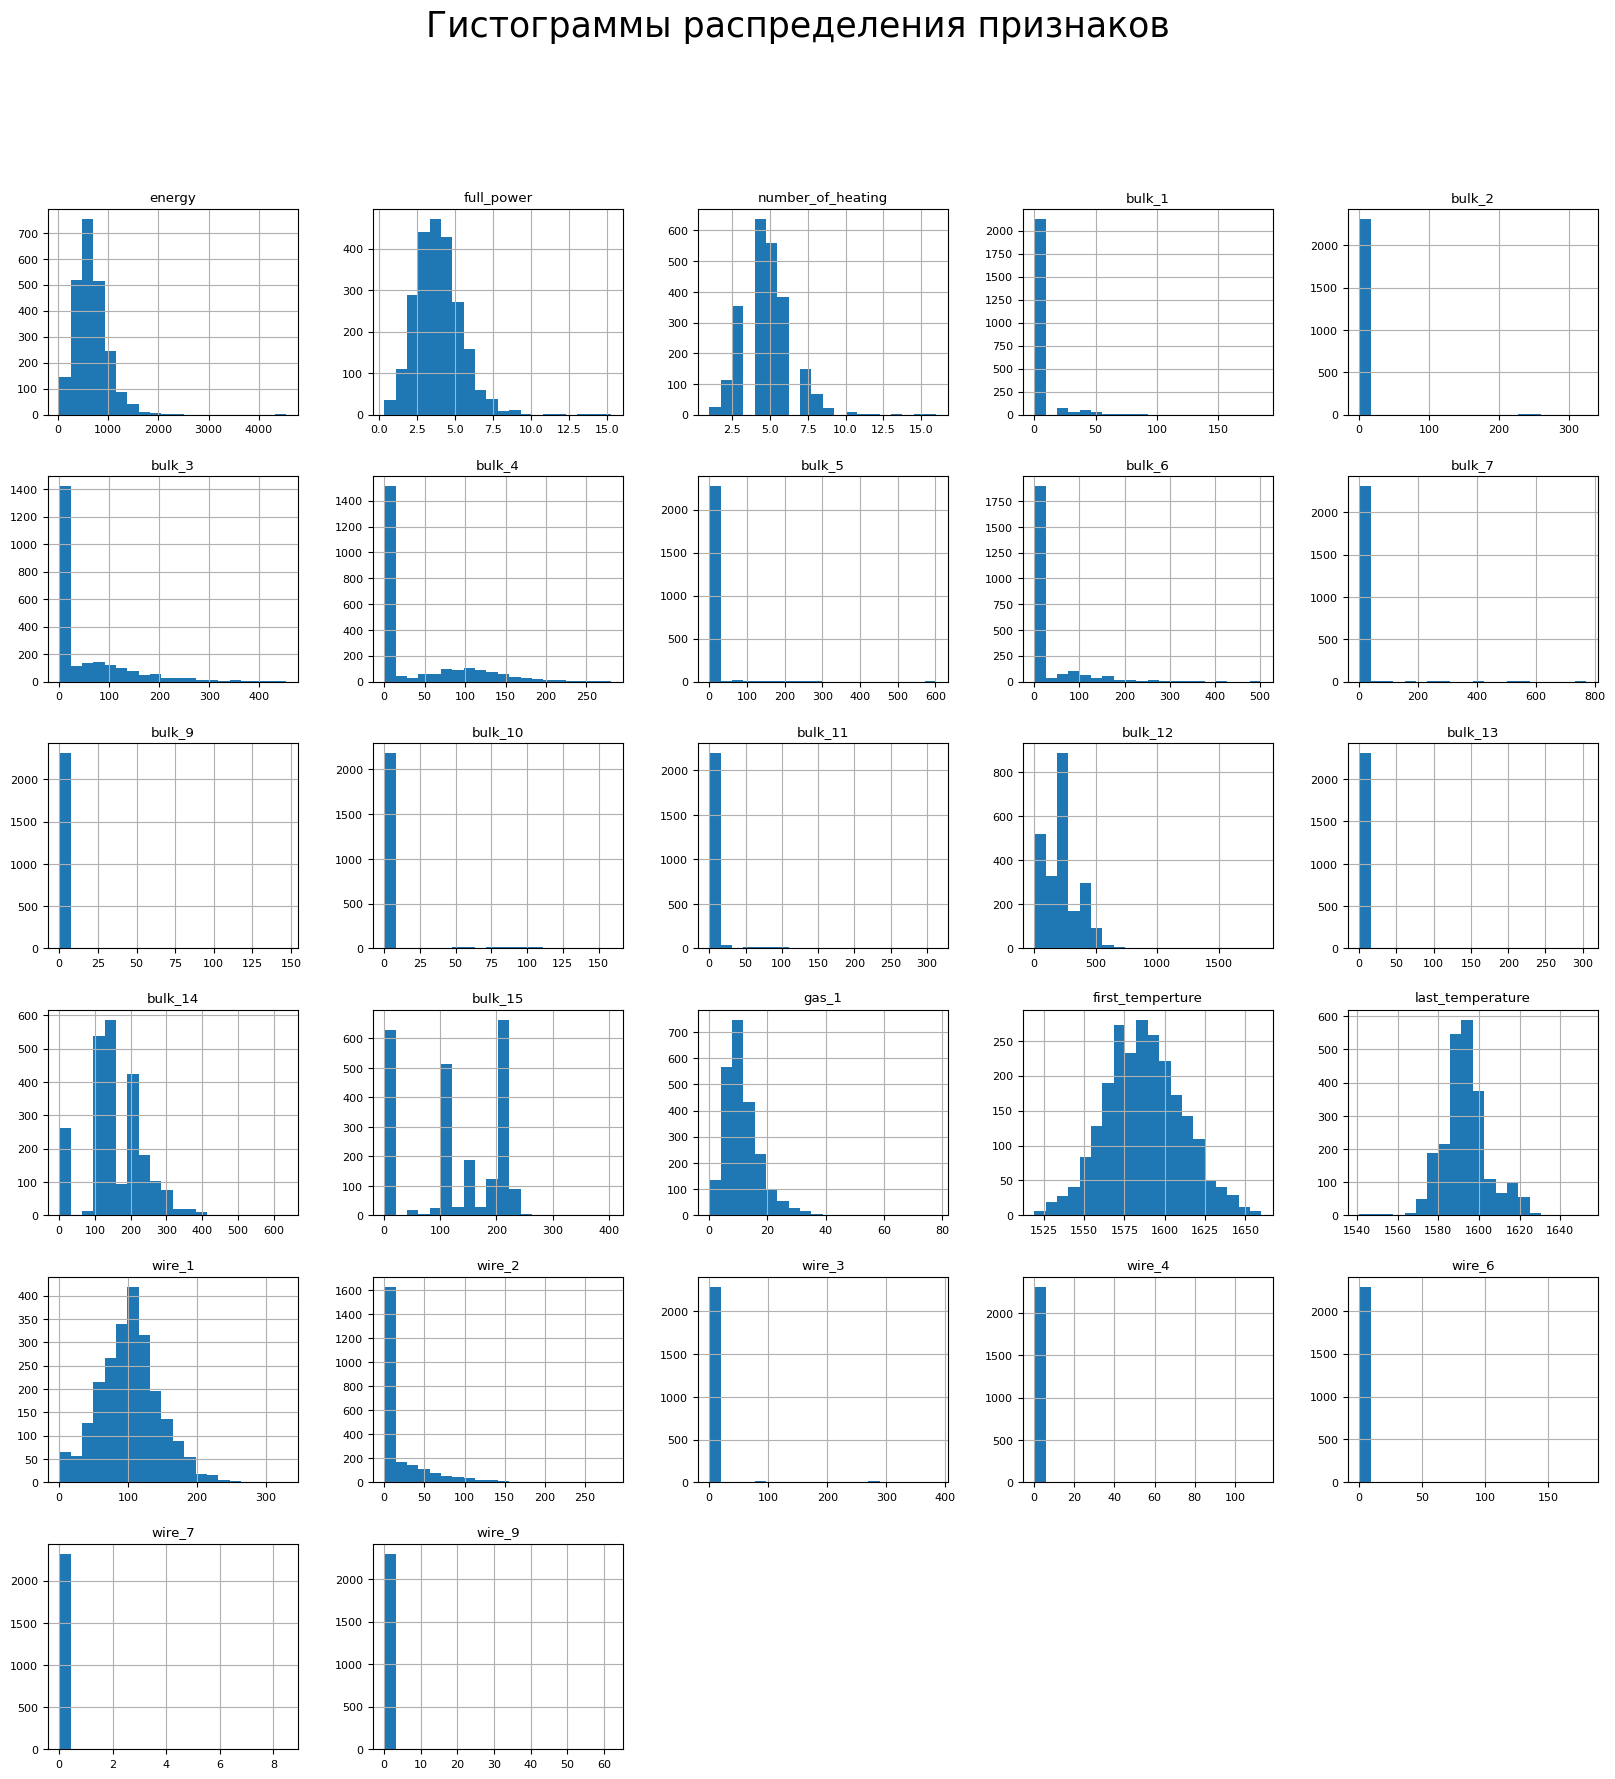

In [81]:
df_merged.hist(figsize=(20, 20), bins=20)
pl.suptitle("Гистограммы распределения признаков", fontsize=25);

In [82]:
df_merged.columns

Index(['energy', 'full_power', 'number_of_heating', 'bulk_1', 'bulk_2',
       'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_9', 'bulk_10',
       'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'gas_1',
       'first_temperture', 'last_temperature', 'wire_1', 'wire_2', 'wire_3',
       'wire_4', 'wire_6', 'wire_7', 'wire_9'],
      dtype='object')

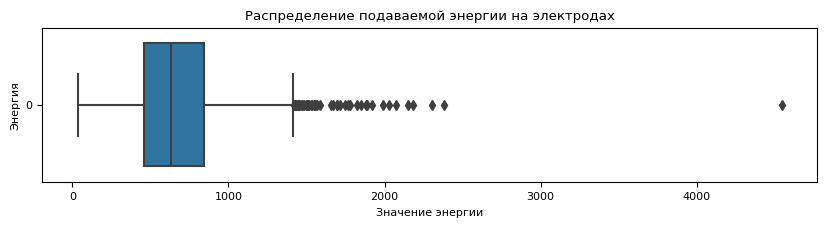

In [83]:
#построим графикираспределения энергии
f, ax = plt.subplots(figsize=(10, 2))
sns.boxplot(data=df_merged['energy'], orient='h')
plt.xlabel('Значение энергии')
plt.ylabel('Энергия')
plt.title('Распределение подаваемой энергии на электродах');

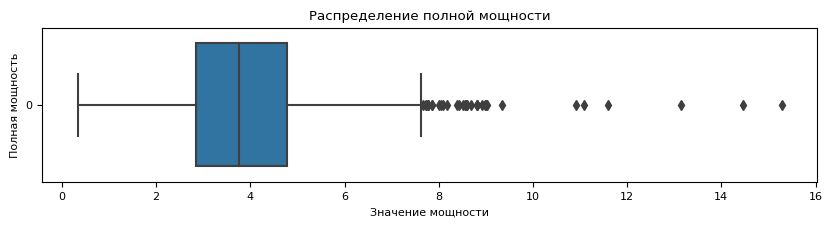

In [84]:
#построим график распределения полной мощности
f, ax = plt.subplots(figsize=(10, 2))
sns.boxplot(data=df_merged['full_power'], orient='h')
plt.xlabel('Значение мощности')
plt.title('Распределение полной мощности')
plt.ylabel('Полная мощность');

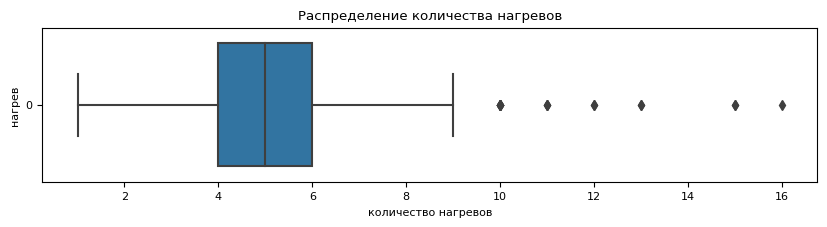

In [85]:
#построим график распределения количества нагревов
f, ax = plt.subplots(figsize=(10, 2))
sns.boxplot(data=df_merged['number_of_heating'], orient='h')
plt.xlabel('количество нагревов')
plt.title('Распределение количества нагревов')
plt.ylabel('нагрев');

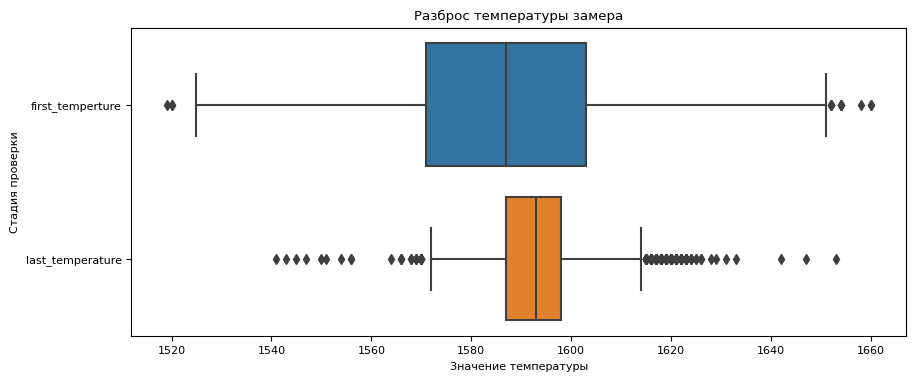

In [86]:
temperature = ['first_temperture', 'last_temperature']

f, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(data=df_merged[temperature], orient='h')
plt.title('Разброс температуры замера')
plt.xlabel('Значение температуры')
plt.ylabel('Стадия проверки');

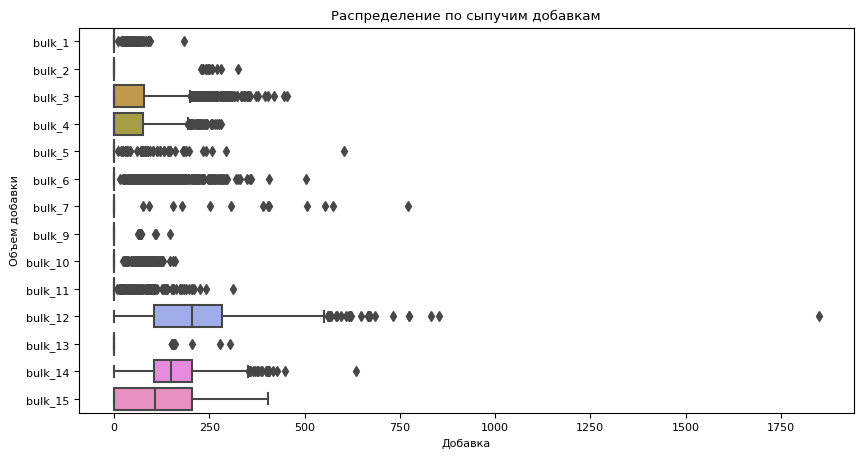

In [87]:
# построим графики распределения
bulk = ['bulk_1', 'bulk_2',
       'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_9', 'bulk_10',
       'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']

f, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df_merged[bulk], orient='h')
plt.title('Распределение по сыпучим добавкам')
plt.xlabel('Добавка')
plt.ylabel('Объем добавки');

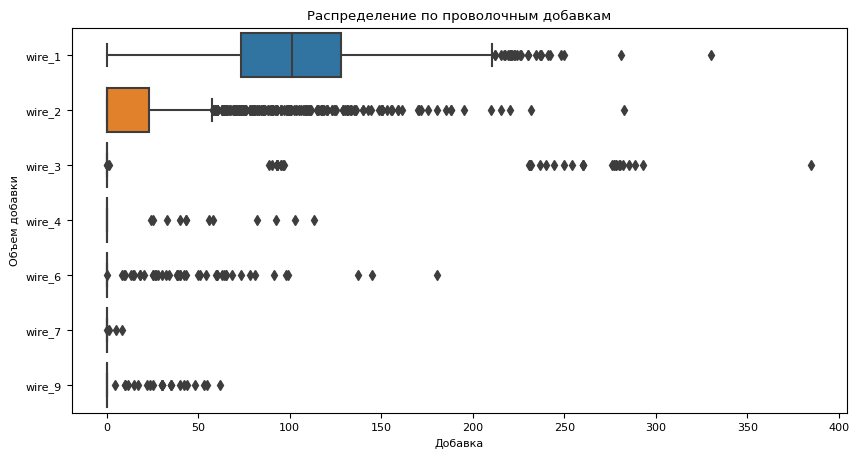

In [88]:
# построим графики распределения по проволочным добавкам
wire = ['wire_1', 'wire_2', 'wire_3',
       'wire_4', 'wire_6', 'wire_7', 'wire_9']

f, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df_merged[wire], orient='h')
plt.title('Распределение по проволочным добавкам')
plt.xlabel('Добавка')
plt.ylabel('Объем добавки');

**ВЫВОД:**  
Были обработаны таблицы с данными:

- Данные об электродах - df_arc  
- Данные о сыпучих материалах (объем) - df_bulk
- Данные о проволочных материалах (объем) - df_wire
- Данные о продувке газом - df_gas
- Данные об измерении температуры - df_temp  

Таблицы с информацией о времени добавки сыпучих или проволочных материалов были исключены за ненадобностью.  

1. В таблице об электродах удалена инормация с ошибочными данными:
- удалили ковши с отрицательным значением реактивной мощности (1 ковш - 4 строки)  
- добавили столбцы с полной мощностью, временем нагрева, энергией, количеством нагревов
- сгрупировали данные по ключу ковша и оставили данные по сумме мощностей, энергии, времени нагрева, а также добавили количество нагревов  
2. В таблицах с информацией об объеме сыпучих и проволочных добавок удалили столбцы с единственной добавкой, пустые значения заполнили нулями.
3. В данных о продуве газом проблем не обнаружено
4. В таблице с измерением температуры удалили данные о ковшах для следующих случаев:  
- имеются температуры менее температуры плавления стали 1450 градусов
- имеются пропущенные значения в замерах температуры
- сделан всего 1 замер температуры  
В таблице оставили значения первого замера и последнего замера

Данные объединили в одну таблицу по ключу 'key' методом 'inner', что позволило не включать в таблицу ковши с отсутствующими данными.  
Проведена проверка данных на корреляцию, в результате чего были удалены признаки с корреляцией больше 0,9.

## Проверка моделей

Разделим выборку на обучающую и тестовую. Размер тестовой выборки должен быть 25%.

In [89]:
features = df_merged.drop('last_temperature', axis=1)
target = df_merged['last_temperature']


features_train, features_test, target_train, target_test = train_test_split(
    features, 
    target, 
    test_size=0.25, 
    random_state=RANDOM_STATE
)

Проверим размер выборок

In [90]:
display(features_train.shape)
display(features_test.shape)
display(target_train.shape)
display(target_test.shape)

(1743, 26)

(581, 26)

(1743,)

(581,)

**Рассмотрим следующие модели:**  
- Линейная регрессия
- CatBoostRegressor
- RandomForestRegressor

### Линейная регрессия

In [91]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test)

In [92]:
model_lr = LinearRegression()

In [93]:
grid_values_lr = {
    'fit_intercept':[True, False]
}

In [94]:
%time
grid_lr = GridSearchCV(
    estimator=model_lr, 
    param_grid=grid_values_lr, 
    scoring='neg_mean_absolute_error',
    cv=3
)
grid_lr.fit(features_train_scaled, target_train)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


GridSearchCV(cv=3, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False]},
             scoring='neg_mean_absolute_error')

In [95]:
score = abs(grid_lr.best_score_)
print(f'MAE линейной регрессии: {score:.2f}')

MAE линейной регрессии: 6.30


### CatBoostRegressor

In [96]:
model_cbr = CatBoostRegressor(verbose=False, random_state=RANDOM_STATE)

In [97]:
grid_values_cbr = {
    'depth': [4, 6, 8],
    'n_estimators': [100, 200, 500]
}

In [98]:
%%time

grid_cbr = GridSearchCV(
    estimator=model_cbr, 
    param_grid=grid_values_cbr,
    scoring='neg_mean_absolute_error',
    cv=3)
grid_cbr.fit(features_train, target_train, verbose=50)

Learning rate set to 0.272573
0:	learn: 10.5281370	total: 48ms	remaining: 4.75s
50:	learn: 6.8921272	total: 79.2ms	remaining: 76.1ms
99:	learn: 5.7956713	total: 104ms	remaining: 0us
Learning rate set to 0.272573
0:	learn: 10.5379262	total: 629us	remaining: 62.3ms
50:	learn: 6.7742391	total: 26.9ms	remaining: 25.9ms
99:	learn: 5.6035103	total: 50ms	remaining: 0us
Learning rate set to 0.272573
0:	learn: 10.5506671	total: 527us	remaining: 52.3ms
50:	learn: 6.7694708	total: 23.3ms	remaining: 22.4ms
99:	learn: 5.6949683	total: 44.3ms	remaining: 0us
Learning rate set to 0.155147
0:	learn: 10.7714471	total: 558us	remaining: 111ms
50:	learn: 7.6429948	total: 20.9ms	remaining: 61.2ms
100:	learn: 6.6206547	total: 41ms	remaining: 40.2ms
150:	learn: 5.9385424	total: 61ms	remaining: 19.8ms
199:	learn: 5.3720600	total: 83.5ms	remaining: 0us
Learning rate set to 0.155147
0:	learn: 10.7853385	total: 702us	remaining: 140ms
50:	learn: 7.5229285	total: 21ms	remaining: 61.3ms
100:	learn: 6.5288053	total: 

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fa8c7e56dd0>,
             param_grid={'depth': [4, 6, 8], 'n_estimators': [100, 200, 500]},
             scoring='neg_mean_absolute_error')

In [99]:
score_cbr = abs(grid_cbr.best_score_)
print(f'MAE CatBoostRegressor: {score_cbr:.2f}')

MAE CatBoostRegressor: 6.41


### RandomForestRegressor

In [100]:
model_forest = RandomForestRegressor(random_state=RANDOM_STATE)

In [101]:
grid_values_forest = {
    'max_depth': [4, 8],
    'n_estimators': [100, 500]
}

In [102]:
%%time

grid_forest = GridSearchCV(
    estimator=model_forest, 
    param_grid=grid_values_forest,
    scoring='neg_mean_absolute_error',
    cv=3)
grid_forest.fit(features_train, target_train)

CPU times: user 13.4 s, sys: 0 ns, total: 13.4 s
Wall time: 13.4 s


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=110923),
             param_grid={'max_depth': [4, 8], 'n_estimators': [100, 500]},
             scoring='neg_mean_absolute_error')

In [103]:
score_forest = abs(grid_forest.best_score_)
print(f'MAE RandomForestRegressor: {score_forest:.2f}')

MAE RandomForestRegressor: 6.58


### Проверка лучшей модели на тестовой выборке

Наилучшей моделью оказалась линейная регрессия с метрикой МАЕ = 6.30

In [104]:
best_model = grid_lr.best_estimator_
grid_lr.best_params_

{'fit_intercept': True}

In [105]:
predict_test = best_model.predict(features_test_scaled)
MAE_score = mean_absolute_error(target_test, predict_test)

print(f'MAE на тестовой выборке: {MAE_score:.2f}')

MAE на тестовой выборке: 6.69


In [106]:
constant_model = DummyRegressor(strategy="median")
constant_model.fit(features_train,target_train)
constant_predict_test = constant_model.predict(features_test)
constant_MAE_score = mean_absolute_error(target_test, constant_predict_test)

print(f'MAE констатной модели на тестовой выборке: {constant_MAE_score:.2f}')


MAE констатной модели на тестовой выборке: 8.12


Метрика линейной регрессии лучше, чем на константной модели

In [107]:
feature_importance = pd.Series(
    grid_lr.best_estimator_.coef_, 
    index=features_test.columns
).sort_values(ascending=False)

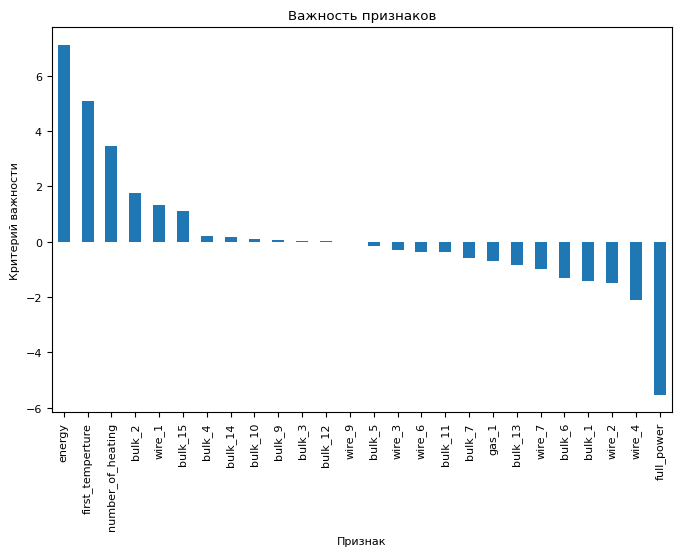

In [108]:
plt.figure(figsize=(8,5))


feature_importance.plot.bar()
plt.title('Важность признаков')
plt.xlabel('Признак')
plt.ylabel('Критерий важности')
plt.show()

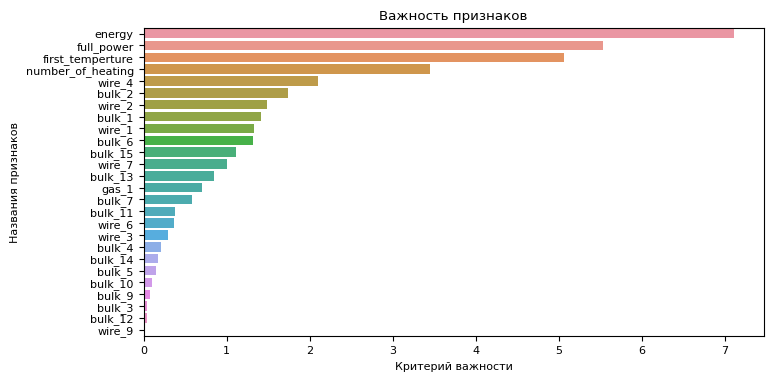

In [109]:
plt.figure(figsize=(8,4))

plot_data = feature_importance.abs().sort_values(ascending=False)

sns.barplot(x=plot_data, y=plot_data.index)

plt.title('Важность признаков')
plt.xlabel('Критерий важности')
plt.ylabel('Названия признаков')
plt.show()

Наиболее важными характеристиками является Энергия и начальная температура


**Вывод:**
В ходе выполнения проекта были загружены данные о процессах нагрева, добавки материалов и продувки метала.

Обучены 3 модели: LinearRegressor, CatBoostRegressor и RandomForestRegressor.
Наилучшей оказалась модель LinearRegressor, которая показала на тестовой выборке МАЕ = 6,69.


## Отчет

Настоящий проект реализует задачу по оптимизации производственных расходов металлургического комбината ООО «Так закаляем сталь» для уменьшения потребления электроэнергии на этапе обработки стали. В рамках проекта построена модель, которая предсказывает температуру стали - умение прогнозировать температуру стали в результате технологических операций (внесение добавок, продувка стали газом, нагрев) позволит снизить затраты на электричество, обслуживание/ремонт.

Для решения задачи предоставленны данные, которые состоят из файлов, полученных из разных источников:

- data_arc_new.csv — данные об электродах;
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
- data_gas_new.csv — данные о продувке сплава газом;
- data_temp_new.csv — результаты измерения температуры;
- data_wire_new.csv — данные о проволочных материалах (объём);
- data_wire_time_new.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

В ходе первоначального ознакомления с данными, был составлен план работы (представлен ниже), а также выявлено, что для последних технологических операций с ковшами имеются большой объем пропущенных значений по температуре - рекомендация заказчику проверить оборудование и при необходимости заменить.

**План выполнения задачи**:

1. Провести предобработку данных по каждой таблице:
- для таблиц с примесями заполнить отсутствующие значения нулями, возможно, удалить редко используемые примеси после согласования с заказчиком
- в таблице с замерами температуры - определить начальные и конечные замеры, удалить те данные ковшей, где отсутствуют начальные и/или конечные замеры температуры, а также те, где температура меньше 1400 градусов.
- в таблице по нагреву сплавов - удалить ошибочные данные с отрицательными значениями реактивной мощности, добавить информацию по общей мощности и затрачиваемой энергии.
2. Объединить таблицы в одну и проверить данные на коллинеарность
3. Обучить несколько моделей, подобрать лучшую по кросс-валидации
4. Проверить лучшую модель на тестовой выборке 0,25% - МАЕ должен быть меньше 6,8

### сравнение решения и плана

В ходе решения проекта в целом ход решения соответствовал плану, были осуществлены дополнительные подпункты плана:  
- в таблице по электродам (нагреву стали) данные сгрупированны по ключам, т.к. для каждого ключа имеется несколько записей - несколько этапов нагрева. Информация по количеству нагревов включена в итоговую таблицу  
- в таблице с примесями удалены записи с примесями, которые использовались всего один раз  
- информаци из таблиц по времени подачи присадок не учитывались за ненадобностью
- приведен вывод важности признаков для лучшей модели



### описание трудностей проекта (и как они были решены) 

Основные трудности проекта:

- Разобраться в технологических процессах предприятия, физических аспектах производственного цикла (общее представление о процессе)
- Структурирование данных, выделение нужных признаков, отсеивание ненужных  
- Построение и оформление графиков

С разбором технологических процессов в данном случае помогла консультация тимлида, который выполнил роль методолога, который собирает информацию, изучает тему производства и предоставляет обобщенную информацию своей команде.

Зная тех.процессы было проще реализовать предобработку данных и выявить основные признаки.

По графикам было получено больше всего замечаний - каких-то графиков не было, какие-то не были грамотно оформлены. С такой проблемой удалось справиться просмотрев предыдущие выполненные проекты с графиками, рекомендации тимлида с ссылками на соответствующий материал, ознакомление с документацией, форумам в интернете

### описание ключевых шагов решения 

#### подготовка данных (склейка, предобработка) 

Были обработаны таблицы с данными:

- Данные об электродах - df_arc  
- Данные о сыпучих материалах (объем) - df_bulk
- Данные о проволочных материалах (объем) - df_wire
- Данные о продувке газом - df_gas
- Данные об измерении температуры - df_temp  

Таблицы с информацией о времени добавки сыпучих или проволочных материалов были исключены за ненадобностью.  

1. В таблице об электродах удалена инормация с ошибочными данными:
- удалили ковши с отрицательным значением реактивной мощности (1 ковш - 4 строки)  
- добавили столбцы с полной мощностью, временем нагрева, энергией, количеством нагревов
- сгрупировали данные по ключу ковша и оставили данные по сумме мощностей, энергии, времени нагрева, а также добавили количество нагревов  
2. В таблицах с информацией об объеме сыпучих и проволочных добавок удалили столбцы с единственной добавкой, пустые значения заполнили нулями.
3. В данных о продуве газом проблем не обнаружено
4. В таблице с измерением температуры удалили данные о ковшах для следующих случаев:  
- имеются температуры менее температуры плавления стали 1450 градусов
- имеются пропущенные значения в замерах температуры
- сделан всего 1 замер температуры  
В таблице оставили значения первого замера и последнего замера

Данные объединили в одну таблицу по ключу 'key' методом 'inner', что позволило не включать в таблицу ковши с отсутствующими данными.  
Проведена проверка данных на корреляцию, в результате чего были удалены признаки с корреляцией больше 0,9.

#### обучение моделей, выбор лучшей и её тестирование 

Для обучения модели, данные были разделены на обучающую и тестовую выборки в отношении 75% / 25%.  
Были рассмотрены 3 модели:  
- Линейная регрессия
- CatBoostRegressor
- RandomForestRegressor  
Для линейной регрессии провели масштабирование данных при помощи StandardScaler().  
Подбор параметров был осуществлен с помощью GridSearchCV.  

### признаки, которые использовали для обучения и их предобработка

Итоговый набор признаков, которые использовались для обучения:  
Информация по нагреву: 'energy', 'full_power', 'number_of_heating'  
Информация по присадкам: 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15',  'wire_1', 'wire_2', 'wire_3','wire_4', 'wire_6', 'wire_7', 'wire_9'  
Информация по продувке газом: 'gas_1'  
Начальная температура сплава: 'first_temperture'  
Признаки с корреляцией больше 0,9 удалены.  
Целевой признак: last_temperature

Разброс начальной температуры больше, чем разброс конечной температуры сплава.  
По присадкам имеются определенные "выбросы" - но из обучающих данных они не были удалены, т.к. это не статистические выбросы, ошибки в данных, а технологические особенности процесса, которые могут определенно влиять на конечную температуру.

### полное описание модели

Наилучшей моделью оказалась Линейная регрессия с подбираемым параметром: 'fit_intercept': True

### итоговая метрика

Метрика MAE наилучшей модели на обучающей выборке: 6,30  
Метрика MAE наилучшей модели на тестовой выборке: 6,69  
Что соответствует условиям задачи, согласно которым MAE должен быть не более 6,8

### рекомендации по улучшению решения 

Для улучшения результатов решения задачи можно предпринять следующие шаги:  
- удалить скоррелированные признаки (на линейной регрессии полная мощность "понижает" температуру  
- перебрать большее количество параметров для моделей CatBoostRegressor, RandomForestRegressor - что может повлечь больше времени на поиск оптимальных параметров  
- применить инструмент Pipeline 